## Plots delays, throughputs, packet loss and path for a selected link

In [2]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.5.*"

my_query = {}

from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

import time
from sklearn.model_selection import train_test_split

import random

from pandas.tseries.offsets import *

#from graphviz import Source

##  Select your link

In [3]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS= 'pic'
srcSiteOWDServer = "193.109.172.188"
#srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS= 'CERN-PROD'
destSiteOWDServer = "128.142.223.247"
#destSiteThroughputServer = "193.109.172.187"

# dS = 'RO-16-UAIC'
# destSiteOWDServer = "85.122.31.74"

# dS = 'praguelcg2'
# destSiteOWDServer = "147.231.25.192"

# dS = 'MWT2'
# destSiteOWDServer = "149.165.225.223"

# dS = 'UFlorida-HPC'
# destSiteOWDServer = "128.227.221.44"

## Get the data from Elasticsearch, and store the record based on its type

In [4]:
my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': '20170510T000000Z', 'lt': '20170530T000000Z'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                #{'term': {'src': srcSiteThroughputServer}},
                                #{'term': {'src': destSiteOWDServer}},
                                #{'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                #{'term': {'dest': destSiteThroughputServer}},
                                #{'term': {'dest': srcSiteOWDServer}},
                                #{'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'_type': 'packet_loss_rate'}},
                                {'term': {'_type': 'latency'}}
                            #{'term': {'_type': ''}},
                            #{'term': {'_type': ''}}
                            ]}
                        }
                    ]
                }
        
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))

In [5]:
site = {srcSiteOWDServer: sS, destSiteOWDServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
print(epoch)

for res in scroll:
    if count<10: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'latency':
        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    #if count<2: print(dt)

1970-01-01 00:00:00
{'_index': 'network_weather-2017.5.19', '_score': None, '_id': 'AVweN7RcKw5l0ihiPru_', 'sort': [1793], '_type': 'latency', '_source': {'delay_median': 80.935, 'destProduction': True, 'delay_sd': 34.584030995629554, 'srcSite': 'pic', 'timestamp': 1495155236000, 'destVO': 'ATLAS', 'delay_mean': 56.55739999999998, 'srcProduction': True, 'dest': '128.142.223.247', 'destSite': 'CERN-PROD', 'src': '193.109.172.188', 'MA': '193.109.172.188', 'srcVO': 'ATLAS'}}
{'_index': 'network_weather-2017.5.19', '_score': None, '_id': 'AVweN7RcKw5l0ihiPrvJ', 'sort': [1794], '_type': 'latency', '_source': {'delay_median': 74.295, 'destProduction': True, 'delay_sd': 16.80342799608825, 'srcSite': 'pic', 'timestamp': 1495154576000, 'destVO': 'ATLAS', 'delay_mean': 52.29361666666668, 'srcProduction': True, 'dest': '128.142.223.247', 'destSite': 'CERN-PROD', 'src': '193.109.172.188', 'MA': '193.109.172.188', 'srcVO': 'ATLAS'}}
{'_index': 'network_weather-2017.5.19', '_score': None, '_id': 'A

In [31]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

,delay_median,delay_mean,delay_sd,packet_loss
count,51330.000000,51330.000000,51330.000000,51330.000000
mean,17.061223,16.723408,4.110248,0.000183
std,8.656560,7.077215,20.767121,0.008582
min,14.140000,7.576117,0.047975,0.000000
25%,15.130000,15.193800,0.197108,0.000000
50%,15.230000,15.304733,0.423081,0.000000
75%,15.350000,15.480038,1.842926,0.000000
max,101.760000,259.434267,937.131766,0.565000


In [32]:
print(data[sS])

                       timestamp  delay_median  delay_mean   delay_sd  \
1.494374e+12 2017-05-10 00:00:42        15.300   15.324867   0.221191   
1.494374e+12 2017-05-10 00:00:46        15.300   15.545550   5.617409   
1.494375e+12 2017-05-10 00:01:42        15.290   15.406417   1.502225   
1.494375e+12 2017-05-10 00:01:46        15.300   15.324650   0.146248   
1.494375e+12 2017-05-10 00:02:42        15.330   15.368233   0.382339   
1.494375e+12 2017-05-10 00:02:46        15.330   15.342733   0.100159   
1.494375e+12 2017-05-10 00:03:42        15.310   15.329317   0.139697   
1.494375e+12 2017-05-10 00:03:46        15.320   15.347617   0.297025   
1.494375e+12 2017-05-10 00:04:42        15.310   15.542367   3.540416   
1.494375e+12 2017-05-10 00:04:46        15.320   15.329467   0.066114   
1.494375e+12 2017-05-10 00:05:42        15.310   15.379550   0.727224   
1.494375e+12 2017-05-10 00:05:51        22.985   15.401933   1.299163   
1.494375e+12 2017-05-10 00:06:42        15.320   15

### Extract values

In [35]:
F = data[sS]
Fpl = F[F.packet_loss.notnull()]
Fd = F[F.delay_mean.notnull()]

print(Fpl)

                       timestamp  delay_median  delay_mean   delay_sd  \
1.494374e+12 2017-05-10 00:00:42        15.300   15.324867   0.221191   
1.494374e+12 2017-05-10 00:00:46        15.300   15.545550   5.617409   
1.494375e+12 2017-05-10 00:01:42        15.290   15.406417   1.502225   
1.494375e+12 2017-05-10 00:01:46        15.300   15.324650   0.146248   
1.494375e+12 2017-05-10 00:02:42        15.330   15.368233   0.382339   
1.494375e+12 2017-05-10 00:02:46        15.330   15.342733   0.100159   
1.494375e+12 2017-05-10 00:03:42        15.310   15.329317   0.139697   
1.494375e+12 2017-05-10 00:03:46        15.320   15.347617   0.297025   
1.494375e+12 2017-05-10 00:04:42        15.310   15.542367   3.540416   
1.494375e+12 2017-05-10 00:04:46        15.320   15.329467   0.066114   
1.494375e+12 2017-05-10 00:05:42        15.310   15.379550   0.727224   
1.494375e+12 2017-05-10 00:05:51        22.985   15.401933   1.299163   
1.494375e+12 2017-05-10 00:06:42        15.320   15

In [36]:
print(Fd)

                       timestamp  delay_median  delay_mean   delay_sd  \
1.494374e+12 2017-05-10 00:00:42        15.300   15.324867   0.221191   
1.494374e+12 2017-05-10 00:00:46        15.300   15.545550   5.617409   
1.494375e+12 2017-05-10 00:01:42        15.290   15.406417   1.502225   
1.494375e+12 2017-05-10 00:01:46        15.300   15.324650   0.146248   
1.494375e+12 2017-05-10 00:02:42        15.330   15.368233   0.382339   
1.494375e+12 2017-05-10 00:02:46        15.330   15.342733   0.100159   
1.494375e+12 2017-05-10 00:03:42        15.310   15.329317   0.139697   
1.494375e+12 2017-05-10 00:03:46        15.320   15.347617   0.297025   
1.494375e+12 2017-05-10 00:04:42        15.310   15.542367   3.540416   
1.494375e+12 2017-05-10 00:04:46        15.320   15.329467   0.066114   
1.494375e+12 2017-05-10 00:05:42        15.310   15.379550   0.727224   
1.494375e+12 2017-05-10 00:05:51        22.985   15.401933   1.299163   
1.494375e+12 2017-05-10 00:06:42        15.320   15

#### interpolate all the values and leave only onese where all 4 measurements are there

In [9]:
# NF=F.interpolate(method='index',limit=1,limit_direction='both')
# NFall = NF[NF.packet_loss.notnull()]
# NFall = NFall[NFall.delay_mean.notnull()]

# print(NFall.shape)

In [10]:
# print(NF.shape)

In [11]:
print( 'packet loss forward: ', Fpl.shape[0])
print( 'delay       forward: ', Fd.shape[0])

packet loss forward:  51330
delay       forward:  51330


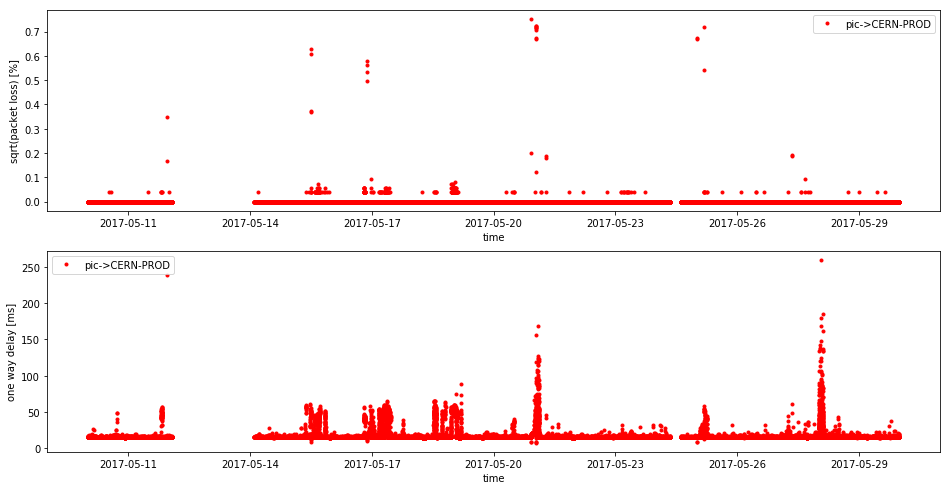

In [12]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 1)

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

ax4 = plt.subplot(gs[2])
ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax4.set_xlabel('time')
ax4.set_ylabel('one way delay [ms]')
ax4.legend()

plt.show()

### Boosted Decision Trees

In [15]:
start_time = time.clock()

# predicted_flag_array = np.zeros((24*3600), dtype=np.int)
# auc_score_array = np.zeros((24*3600), dtype=np.float)
# score_holder_array = np.zeros(3600, dtype=np.float)
# anomaly_array = np.ones(3600, dtype=np.int)
# not_anomaly_array = np.zeros(3600, dtype=np.int)

In [16]:
n_series = 1
start_date = '2017-05-10 00:00:00'
end_date = '2017-05-30 23:59:59'

window = 24

In [17]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['auc_score']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['auc_score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=50)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=50)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    clf = AdaBoostClassifier(n_estimators=50)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ( "auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > 0.55: 
        plot_roc(fpr, tpr, auc_score)
        #filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        #tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        #tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [18]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
start_date = Fpl['timestamp'].min()
print(start_date)
end_date = Fpl['timestamp'].max()
print(end_date)

#print(Fpl.index/1000 - 1502668800.0)

Fpl2 = Fpl.set_index('timestamp')
Fpl2['auc_score']=0.5
print(Fpl2)

2017-05-10 00:00:42
2017-05-29 23:59:38
                     delay_median  delay_mean   delay_sd  packet_loss  \
timestamp                                                               
2017-05-10 00:00:42        15.300   15.324867   0.221191          0.0   
2017-05-10 00:00:46        15.300   15.545550   5.617409          0.0   
2017-05-10 00:01:42        15.290   15.406417   1.502225          0.0   
2017-05-10 00:01:46        15.300   15.324650   0.146248          0.0   
2017-05-10 00:02:42        15.330   15.368233   0.382339          0.0   
2017-05-10 00:02:46        15.330   15.342733   0.100159          0.0   
2017-05-10 00:03:42        15.310   15.329317   0.139697          0.0   
2017-05-10 00:03:46        15.320   15.347617   0.297025          0.0   
2017-05-10 00:04:42        15.310   15.542367   3.540416          0.0   
2017-05-10 00:04:46        15.320   15.329467   0.066114          0.0   
2017-05-10 00:05:42        15.310   15.379550   0.727224          0.0   
2017-05-10 

In [20]:
print(Fpl2.index)

DatetimeIndex(['2017-05-10 00:00:42', '2017-05-10 00:00:46',
               '2017-05-10 00:01:42', '2017-05-10 00:01:46',
               '2017-05-10 00:02:42', '2017-05-10 00:02:46',
               '2017-05-10 00:03:42', '2017-05-10 00:03:46',
               '2017-05-10 00:04:42', '2017-05-10 00:04:46',
               ...
               '2017-05-29 23:55:33', '2017-05-29 23:55:35',
               '2017-05-29 23:56:33', '2017-05-29 23:56:35',
               '2017-05-29 23:57:33', '2017-05-29 23:57:35',
               '2017-05-29 23:58:35', '2017-05-29 23:58:38',
               '2017-05-29 23:59:35', '2017-05-29 23:59:38'],
              dtype='datetime64[ns]', name='timestamp', length=51330, freq=None)


timestamp =  2017-05-11 00:00:42
auc_score =  0.499418604651 	feature importances: [ 0.32  0.46  0.22  0.  ]
timestamp =  2017-05-11 01:00:42
auc_score =  0.498255813953 	feature importances: [ 0.32  0.34  0.34  0.  ]
timestamp =  2017-05-11 02:00:42
auc_score =  0.5 	feature importances: [ 0.3  0.3  0.4  0. ]
timestamp =  2017-05-11 03:00:42
auc_score =  0.499418604651 	feature importances: [ 0.4   0.32  0.28  0.  ]
timestamp =  2017-05-11 04:00:42
auc_score =  0.499418604651 	feature importances: [ 0.26  0.38  0.36  0.  ]
timestamp =  2017-05-11 05:00:42
auc_score =  0.5 	feature importances: [ 0.26  0.3   0.44  0.  ]
timestamp =  2017-05-11 06:00:42
auc_score =  0.5 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-11 07:00:42
auc_score =  0.511563307494 	feature importances: [ 0.28  0.32  0.4   0.  ]
timestamp =  2017-05-11 08:00:42
auc_score =  0.498255813953 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-11 09:00:42
auc_score =  0.52487080

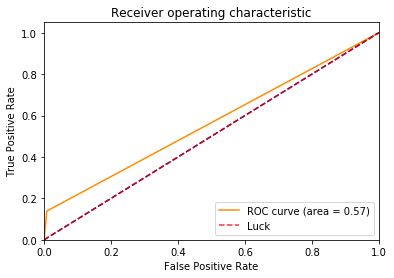

timestamp =  2017-05-11 13:00:42
auc_score =  0.498838559814 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-11 14:00:42
auc_score =  0.525452196382 	feature importances: [ 0.46  0.32  0.22  0.  ]
timestamp =  2017-05-11 15:00:42
auc_score =  0.524289405685 	feature importances: [ 0.34  0.3   0.36  0.  ]
timestamp =  2017-05-11 16:00:42
auc_score =  0.498257839721 	feature importances: [ 0.46  0.3   0.24  0.  ]
timestamp =  2017-05-11 17:00:42
auc_score =  0.497093023256 	feature importances: [ 0.42  0.32  0.26  0.  ]
timestamp =  2017-05-11 18:00:42
auc_score =  0.5 	feature importances: [ 0.26  0.34  0.4   0.  ]
timestamp =  2017-05-11 19:00:42
auc_score =  0.719318621758 	feature importances: [ 0.4  0.3  0.3  0. ]


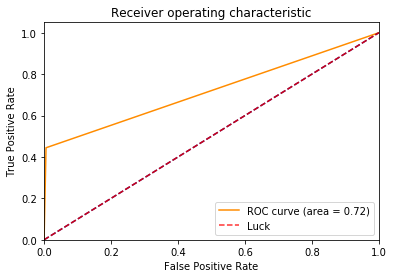

timestamp =  2017-05-11 20:00:42
auc_score =  0.549748354626 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-11 21:00:42
auc_score =  0.5 	feature importances: [ 0.64  0.22  0.14  0.  ]
timestamp =  2017-05-11 22:00:42
auc_score =  0.512727448703 	feature importances: [ 0.38  0.38  0.24  0.  ]
timestamp =  2017-05-11 23:00:42
auc_score =  0.498838559814 	feature importances: [ 0.4   0.32  0.26  0.02]
timestamp =  2017-05-12 00:00:42
auc_score =  0.5 	feature importances: [ 0.3   0.36  0.34  0.  ]
timestamp =  2017-05-12 01:00:42
auc_score =  0.498838559814 	feature importances: [ 0.34  0.4   0.26  0.  ]
timestamp =  2017-05-14 03:00:42
auc_score =  0.710784313725 	feature importances: [ 0.26  0.4   0.34  0.  ]


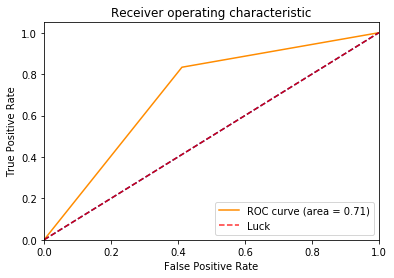

timestamp =  2017-05-14 04:00:42
auc_score =  0.776205450734 	feature importances: [ 0.34  0.36  0.28  0.02]


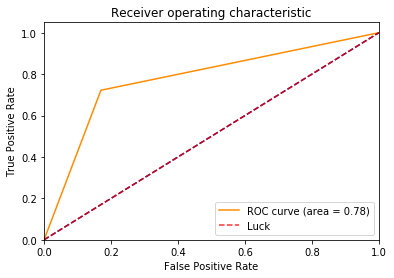

timestamp =  2017-05-14 05:00:42
auc_score =  0.860486891386 	feature importances: [ 0.26  0.52  0.22  0.  ]


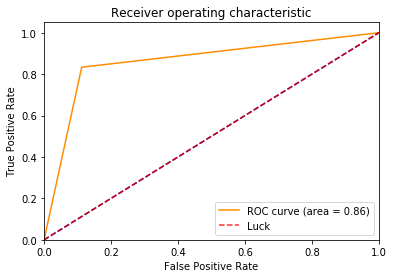

timestamp =  2017-05-14 06:00:42
auc_score =  0.71027027027 	feature importances: [ 0.22  0.34  0.44  0.  ]


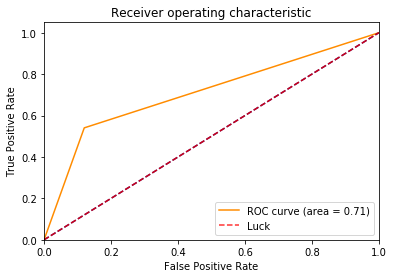

timestamp =  2017-05-14 07:00:42
auc_score =  0.567632850242 	feature importances: [ 0.4  0.4  0.2  0. ]


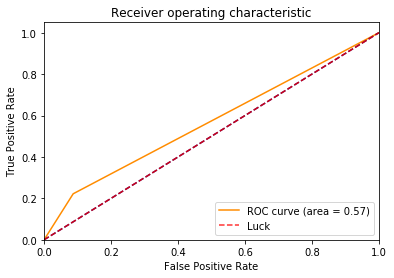

timestamp =  2017-05-14 08:00:42
auc_score =  0.56676536943 	feature importances: [ 0.26  0.3   0.44  0.  ]


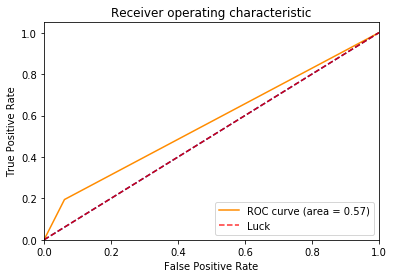

timestamp =  2017-05-14 09:00:42
auc_score =  0.633464473057 	feature importances: [ 0.26  0.3   0.44  0.  ]


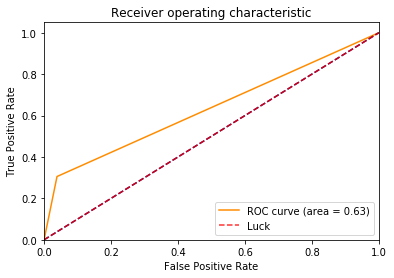

timestamp =  2017-05-14 10:00:42
auc_score =  0.816604708798 	feature importances: [ 0.42  0.24  0.34  0.  ]


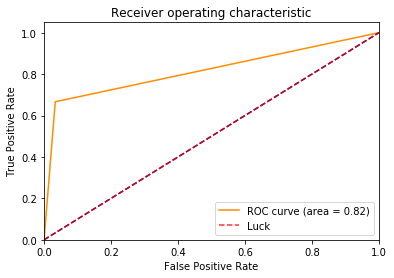

timestamp =  2017-05-14 11:00:42
auc_score =  0.672358834244 	feature importances: [ 0.52  0.32  0.16  0.  ]


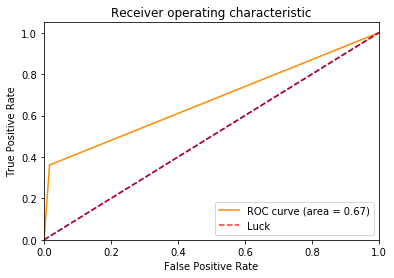

timestamp =  2017-05-14 12:00:42
auc_score =  0.509490061909 	feature importances: [ 0.46  0.34  0.2   0.  ]
timestamp =  2017-05-14 13:00:42
auc_score =  0.940465664604 	feature importances: [ 0.26  0.3   0.44  0.  ]


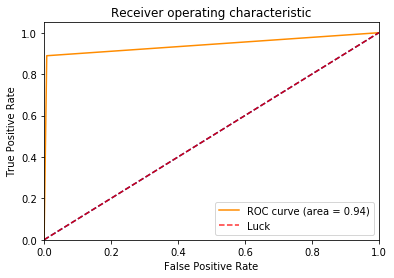

timestamp =  2017-05-14 14:00:42
auc_score =  0.527777777778 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-14 15:00:42
auc_score =  0.627728174603 	feature importances: [ 0.5   0.24  0.26  0.  ]


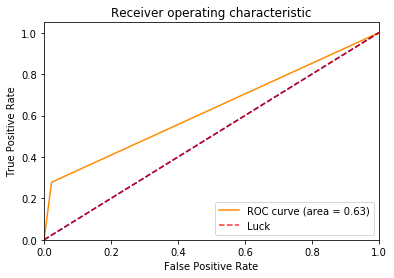

timestamp =  2017-05-14 16:00:42
auc_score =  0.494834710744 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-14 17:00:42
auc_score =  0.631196581197 	feature importances: [ 0.3   0.32  0.38  0.  ]


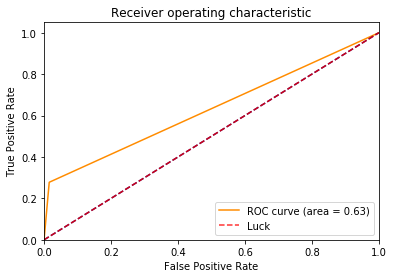

timestamp =  2017-05-14 18:00:42
auc_score =  0.498201438849 	feature importances: [ 0.3   0.36  0.34  0.  ]
timestamp =  2017-05-14 19:00:42
auc_score =  0.511355105105 	feature importances: [ 0.26  0.56  0.18  0.  ]
timestamp =  2017-05-14 20:00:42
auc_score =  0.512296532201 	feature importances: [ 0.4   0.32  0.28  0.  ]
timestamp =  2017-05-14 21:00:42
auc_score =  0.525518741633 	feature importances: [ 0.28  0.28  0.44  0.  ]
timestamp =  2017-05-14 22:00:42
auc_score =  0.593650793651 	feature importances: [ 0.52  0.28  0.2   0.  ]


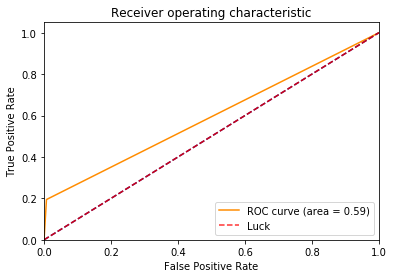

timestamp =  2017-05-14 23:00:42
auc_score =  0.497961956522 	feature importances: [ 0.4   0.24  0.36  0.  ]
timestamp =  2017-05-15 00:00:42
auc_score =  0.498051948052 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-15 01:00:42
auc_score =  0.499379652605 	feature importances: [ 0.36  0.32  0.32  0.  ]
timestamp =  2017-05-15 02:00:42
auc_score =  0.498812351544 	feature importances: [ 0.36  0.4   0.24  0.  ]
timestamp =  2017-05-15 03:00:42
auc_score =  0.499420625724 	feature importances: [ 0.44  0.28  0.28  0.  ]
timestamp =  2017-05-15 04:00:42
auc_score =  0.5 	feature importances: [ 0.28  0.46  0.26  0.  ]
timestamp =  2017-05-15 05:00:42
auc_score =  0.5 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-15 06:00:42
auc_score =  0.499419953596 	feature importances: [ 0.32  0.34  0.34  0.  ]
timestamp =  2017-05-15 07:00:42
auc_score =  0.512148749678 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05-15 08:00:42
auc_scor

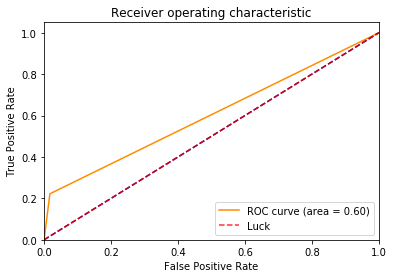

timestamp =  2017-05-15 11:00:42
auc_score =  0.651619029226 	feature importances: [ 0.34  0.24  0.42  0.  ]


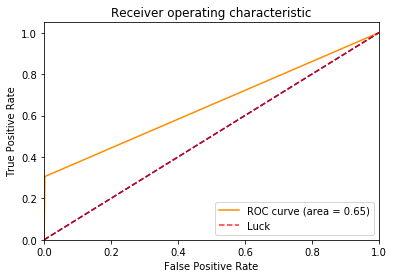

timestamp =  2017-05-15 12:00:42
auc_score =  0.527197731374 	feature importances: [ 0.48  0.26  0.24  0.02]
timestamp =  2017-05-15 13:00:42
auc_score =  0.512728796081 	feature importances: [ 0.38  0.34  0.28  0.  ]
timestamp =  2017-05-15 14:00:42
auc_score =  0.537606341841 	feature importances: [ 0.24  0.5   0.24  0.02]
timestamp =  2017-05-15 15:00:42
auc_score =  0.605317368353 	feature importances: [ 0.26  0.42  0.32  0.  ]


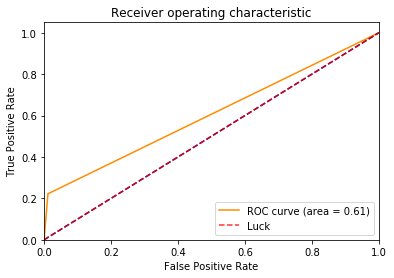

timestamp =  2017-05-15 16:00:42
auc_score =  0.563071327411 	feature importances: [ 0.32  0.34  0.34  0.  ]


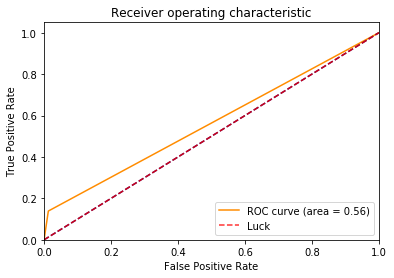

timestamp =  2017-05-15 17:00:42
auc_score =  0.499420625724 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-15 18:00:42
auc_score =  0.495365005794 	feature importances: [ 0.4   0.34  0.22  0.04]
timestamp =  2017-05-15 19:00:42
auc_score =  0.499420625724 	feature importances: [ 0.26  0.54  0.2   0.  ]
timestamp =  2017-05-15 20:00:42
auc_score =  0.497103128621 	feature importances: [ 0.38  0.34  0.26  0.02]
timestamp =  2017-05-15 21:00:42
auc_score =  0.498841251448 	feature importances: [ 0.28  0.46  0.26  0.  ]
timestamp =  2017-05-15 22:00:42
auc_score =  0.663190421012 	feature importances: [ 0.32  0.48  0.18  0.02]


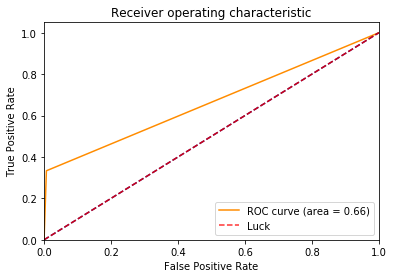

timestamp =  2017-05-15 23:00:42
auc_score =  0.540536957242 	feature importances: [ 0.4   0.26  0.34  0.  ]
timestamp =  2017-05-16 00:00:42
auc_score =  0.703118964851 	feature importances: [ 0.22  0.44  0.34  0.  ]


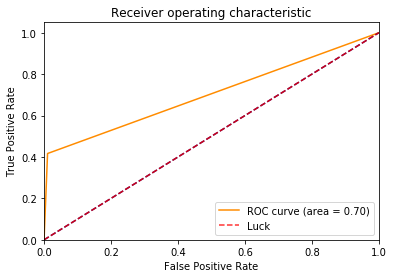

timestamp =  2017-05-16 01:00:42
auc_score =  0.499420625724 	feature importances: [ 0.28  0.28  0.44  0.  ]
timestamp =  2017-05-16 02:00:42
auc_score =  0.498841251448 	feature importances: [ 0.34  0.26  0.4   0.  ]
timestamp =  2017-05-16 03:00:42
auc_score =  0.499419279907 	feature importances: [ 0.26  0.34  0.4   0.  ]
timestamp =  2017-05-16 04:00:42
auc_score =  0.499419279907 	feature importances: [ 0.28  0.38  0.34  0.  ]
timestamp =  2017-05-16 05:00:42
auc_score =  0.676490514905 	feature importances: [ 0.18  0.38  0.44  0.  ]


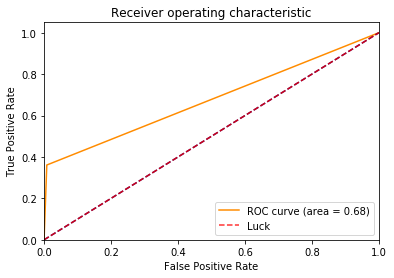

timestamp =  2017-05-16 06:00:42
auc_score =  0.497096399535 	feature importances: [ 0.3   0.26  0.42  0.02]
timestamp =  2017-05-16 07:00:42
auc_score =  0.550909794812 	feature importances: [ 0.5   0.26  0.22  0.02]


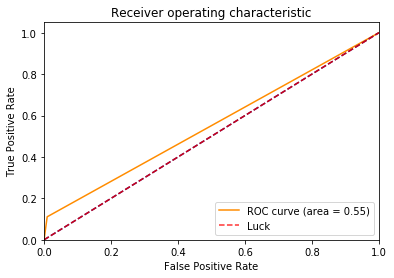

timestamp =  2017-05-16 08:00:42
auc_score =  0.498838559814 	feature importances: [ 0.24  0.36  0.38  0.02]
timestamp =  2017-05-16 09:00:42
auc_score =  0.526616337592 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-16 10:00:42
auc_score =  0.498838559814 	feature importances: [ 0.56  0.3   0.14  0.  ]
timestamp =  2017-05-16 11:00:42
auc_score =  0.509243128146 	feature importances: [ 0.3  0.4  0.3  0. ]
timestamp =  2017-05-16 12:00:42
auc_score =  0.499418604651 	feature importances: [ 0.38  0.32  0.3   0.  ]
timestamp =  2017-05-16 13:00:42
auc_score =  0.5 	feature importances: [ 0.34  0.5   0.16  0.  ]
timestamp =  2017-05-16 14:00:42
auc_score =  0.499419279907 	feature importances: [ 0.32  0.34  0.34  0.  ]
timestamp =  2017-05-16 15:00:42
auc_score =  0.539343786295 	feature importances: [ 0.38  0.32  0.3   0.  ]
timestamp =  2017-05-16 16:00:42
auc_score =  0.498838559814 	feature importances: [ 0.22  0.6   0.18  0.  ]
timestamp =  2017-05-16 17:00:42
a

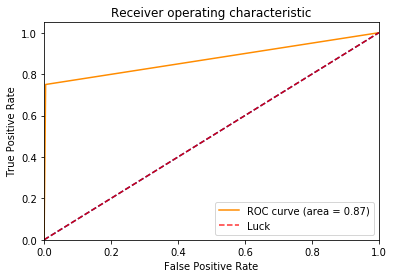

timestamp =  2017-05-16 20:00:42
auc_score =  0.499418604651 	feature importances: [ 0.4   0.28  0.3   0.02]
timestamp =  2017-05-16 21:00:42
auc_score =  0.972222222222 	feature importances: [ 0.14  0.64  0.22  0.  ]


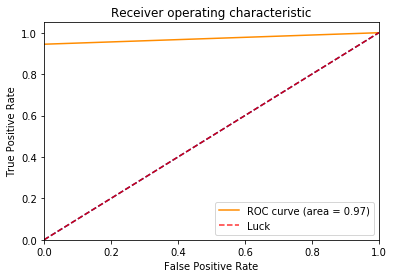

timestamp =  2017-05-16 22:00:42
auc_score =  0.839082687339 	feature importances: [ 0.24  0.4   0.36  0.  ]


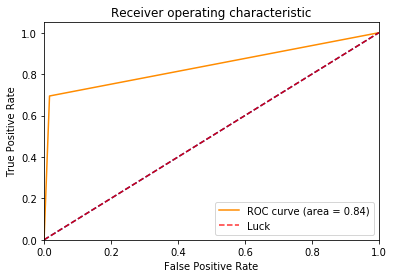

timestamp =  2017-05-16 23:00:42
auc_score =  0.528831044613 	feature importances: [ 0.36  0.34  0.28  0.02]
timestamp =  2017-05-17 00:00:42
auc_score =  0.497671711292 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-17 01:00:42
auc_score =  0.5 	feature importances: [ 0.4   0.26  0.34  0.  ]
timestamp =  2017-05-17 02:00:42
auc_score =  0.537592161428 	feature importances: [ 0.38  0.42  0.2   0.  ]
timestamp =  2017-05-17 03:00:42
auc_score =  0.499418604651 	feature importances: [ 0.44  0.34  0.22  0.  ]
timestamp =  2017-05-17 04:00:42
auc_score =  0.637726098191 	feature importances: [ 0.34  0.28  0.38  0.  ]


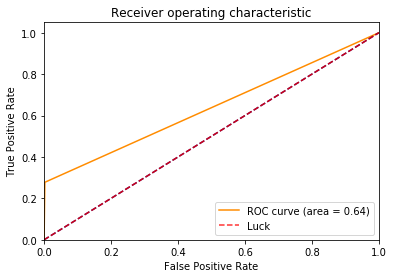

timestamp =  2017-05-17 05:00:42
auc_score =  0.497674418605 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-17 06:00:42
auc_score =  0.499417927823 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-17 07:00:42
auc_score =  0.759819121447 	feature importances: [ 0.26  0.26  0.46  0.02]


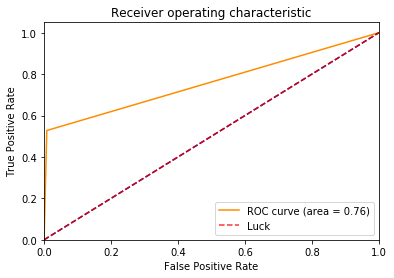

timestamp =  2017-05-17 08:00:42
auc_score =  0.60645994832 	feature importances: [ 0.38  0.22  0.4   0.  ]


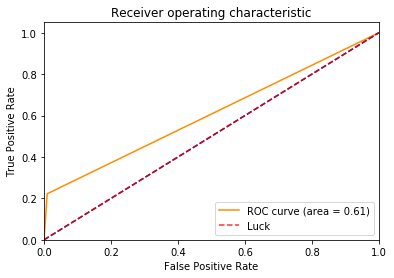

timestamp =  2017-05-17 09:00:42
auc_score =  0.541666666667 	feature importances: [ 0.34  0.24  0.42  0.  ]
timestamp =  2017-05-17 10:00:42
auc_score =  0.539338377959 	feature importances: [ 0.5   0.3   0.18  0.02]
timestamp =  2017-05-17 11:00:42
auc_score =  0.549734833786 	feature importances: [ 0.48  0.3   0.22  0.  ]
timestamp =  2017-05-17 12:00:42
auc_score =  0.678811369509 	feature importances: [ 0.38  0.28  0.34  0.  ]


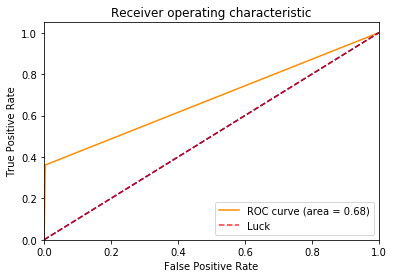

timestamp =  2017-05-17 13:00:42
auc_score =  0.744186046512 	feature importances: [ 0.52  0.22  0.26  0.  ]


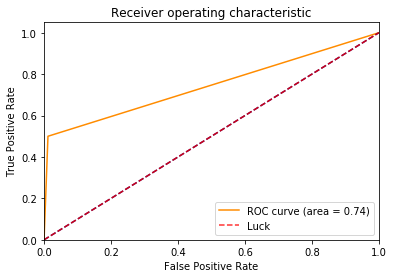

timestamp =  2017-05-17 14:00:42
auc_score =  0.732041343669 	feature importances: [ 0.4   0.28  0.32  0.  ]


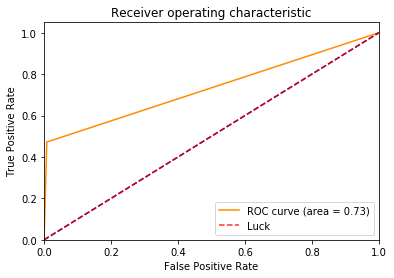

timestamp =  2017-05-17 15:00:42
auc_score =  0.510400516796 	feature importances: [ 0.48  0.34  0.18  0.  ]
timestamp =  2017-05-17 16:00:42
auc_score =  0.52661498708 	feature importances: [ 0.34  0.5   0.16  0.  ]
timestamp =  2017-05-17 17:00:42
auc_score =  0.498255813953 	feature importances: [ 0.34  0.26  0.4   0.  ]
timestamp =  2017-05-17 18:00:42
auc_score =  0.550322997416 	feature importances: [ 0.38  0.34  0.28  0.  ]


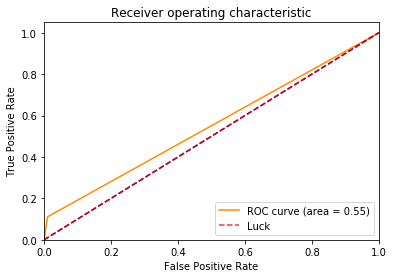

timestamp =  2017-05-17 19:00:42
auc_score =  0.512724744535 	feature importances: [ 0.34  0.48  0.18  0.  ]
timestamp =  2017-05-17 20:00:42
auc_score =  0.527196382429 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-17 21:00:42
auc_score =  0.526033591731 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-17 22:00:42
auc_score =  0.538759689922 	feature importances: [ 0.3   0.38  0.32  0.  ]
timestamp =  2017-05-17 23:00:42
auc_score =  0.510211209047 	feature importances: [ 0.26  0.28  0.46  0.  ]
timestamp =  2017-05-18 00:00:42
auc_score =  0.5 	feature importances: [ 0.28  0.46  0.26  0.  ]
timestamp =  2017-05-18 01:00:42
auc_score =  0.529900332226 	feature importances: [ 0.26  0.42  0.32  0.  ]
timestamp =  2017-05-18 02:00:42
auc_score =  0.5 	feature importances: [ 0.3   0.48  0.22  0.  ]
timestamp =  2017-05-18 03:00:42
auc_score =  0.49940688019 	feature importances: [ 0.32  0.3   0.38  0.  ]
timestamp =  2017-05-18 04:00:42
auc_score

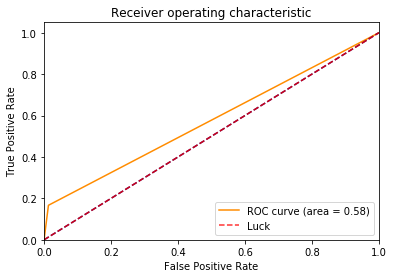

timestamp =  2017-05-18 06:00:42
auc_score =  0.788701067616 	feature importances: [ 0.42  0.26  0.32  0.  ]


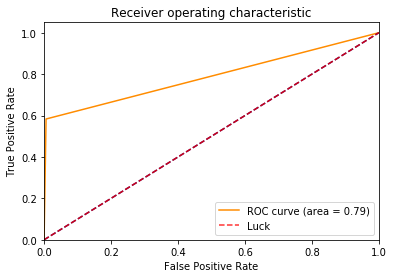

timestamp =  2017-05-18 07:00:42
auc_score =  0.633550810597 	feature importances: [ 0.3   0.34  0.36  0.  ]


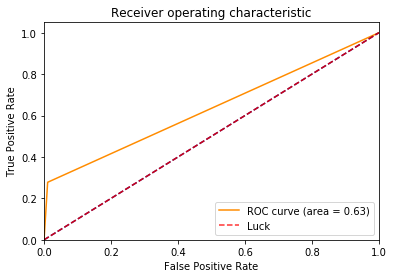

timestamp =  2017-05-18 08:00:42
auc_score =  0.650405298537 	feature importances: [ 0.38  0.32  0.3   0.  ]


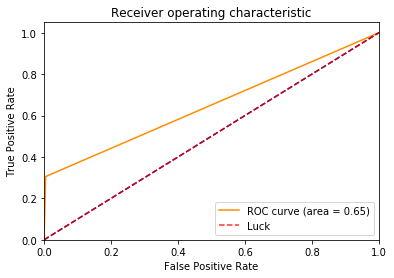

timestamp =  2017-05-18 09:00:42
auc_score =  0.49940688019 	feature importances: [ 0.58  0.32  0.1   0.  ]
timestamp =  2017-05-18 10:00:42
auc_score =  0.512702649268 	feature importances: [ 0.38  0.34  0.28  0.  ]
timestamp =  2017-05-18 11:00:42
auc_score =  0.510926803581 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-18 12:00:42
auc_score =  0.74644549763 	feature importances: [ 0.3   0.32  0.38  0.  ]


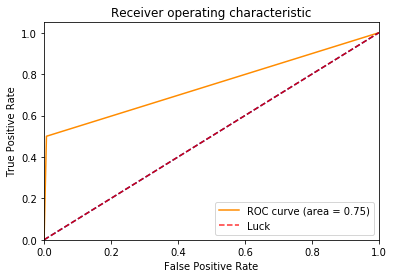

timestamp =  2017-05-18 13:00:42
auc_score =  0.795472518782 	feature importances: [ 0.4   0.28  0.3   0.02]


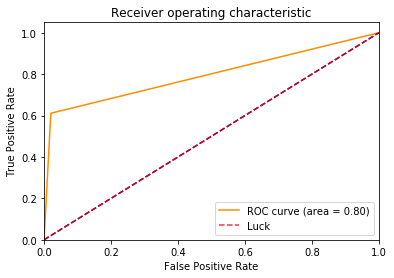

timestamp =  2017-05-18 14:00:42
auc_score =  0.524812178727 	feature importances: [ 0.52  0.08  0.4   0.  ]
timestamp =  2017-05-18 15:00:42
auc_score =  0.598062475287 	feature importances: [ 0.42  0.24  0.34  0.  ]


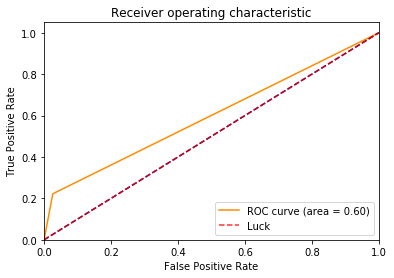

timestamp =  2017-05-18 16:00:42
auc_score =  0.49940688019 	feature importances: [ 0.46  0.24  0.3   0.  ]
timestamp =  2017-05-18 17:00:42
auc_score =  0.510923289838 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-18 18:00:42
auc_score =  0.5 	feature importances: [ 0.38  0.3   0.32  0.  ]
timestamp =  2017-05-18 19:00:42
auc_score =  0.497034400949 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-18 20:00:42
auc_score =  0.541073546856 	feature importances: [ 0.48  0.2   0.32  0.  ]
timestamp =  2017-05-18 21:00:42
auc_score =  0.49940688019 	feature importances: [ 0.44  0.26  0.3   0.  ]
timestamp =  2017-05-18 22:00:42
auc_score =  0.513295769079 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-18 23:00:42
auc_score =  0.968510730077 	feature importances: [ 0.3   0.42  0.26  0.02]


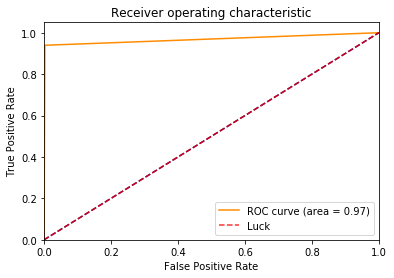

timestamp =  2017-05-19 00:00:42
auc_score =  0.730766693059 	feature importances: [ 0.4   0.28  0.32  0.  ]


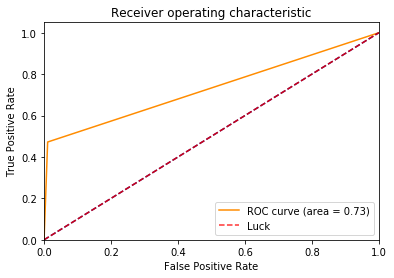

timestamp =  2017-05-19 01:00:42
auc_score =  0.512105297926 	feature importances: [ 0.22  0.3   0.48  0.  ]
timestamp =  2017-05-19 02:00:42
auc_score =  0.524453781513 	feature importances: [ 0.34  0.42  0.24  0.  ]
timestamp =  2017-05-19 03:00:42
auc_score =  0.542998833139 	feature importances: [ 0.24  0.32  0.44  0.  ]
timestamp =  2017-05-19 04:00:42
auc_score =  0.608173390782 	feature importances: [ 0.7   0.14  0.16  0.  ]


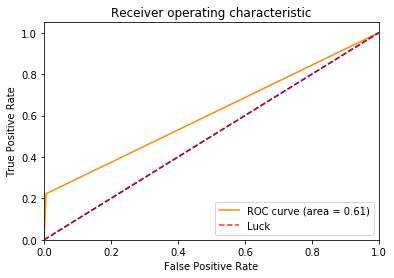

timestamp =  2017-05-19 05:00:42
auc_score =  0.51095116856 	feature importances: [ 0.32  0.4   0.28  0.  ]
timestamp =  2017-05-19 06:00:42
auc_score =  0.513301344823 	feature importances: [ 0.52  0.38  0.1   0.  ]
timestamp =  2017-05-19 07:00:42
auc_score =  0.527777777778 	feature importances: [ 0.34  0.34  0.32  0.  ]
timestamp =  2017-05-19 08:00:42
auc_score =  0.52601514558 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-19 09:00:42
auc_score =  0.513301344823 	feature importances: [ 0.34  0.42  0.24  0.  ]
timestamp =  2017-05-19 10:00:42
auc_score =  0.621474735605 	feature importances: [ 0.4  0.3  0.3  0. ]


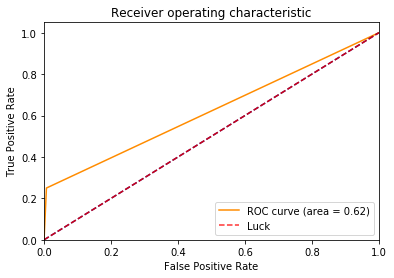

timestamp =  2017-05-19 11:00:42
auc_score =  0.499412455934 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-19 12:00:42
auc_score =  0.527190233712 	feature importances: [ 0.34  0.44  0.22  0.  ]
timestamp =  2017-05-19 13:00:42
auc_score =  0.497062279671 	feature importances: [ 0.26  0.44  0.3   0.  ]
timestamp =  2017-05-19 14:00:42
auc_score =  0.565331635984 	feature importances: [ 0.38  0.38  0.24  0.  ]


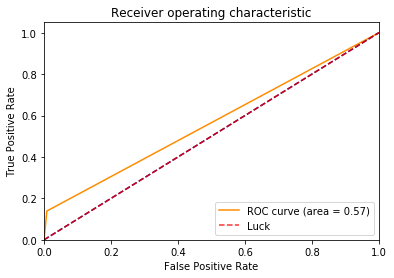

timestamp =  2017-05-19 15:00:42
auc_score =  0.606410758585 	feature importances: [ 0.34  0.52  0.14  0.  ]


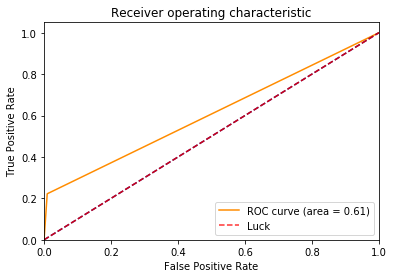

timestamp =  2017-05-19 16:00:42
auc_score =  0.64690233712 	feature importances: [ 0.28  0.4   0.32  0.  ]


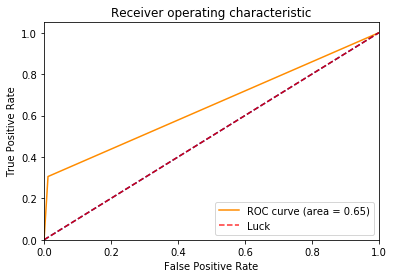

timestamp =  2017-05-19 17:00:42
auc_score =  0.759776080428 	feature importances: [ 0.5  0.3  0.2  0. ]


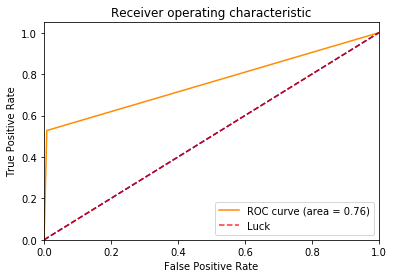

timestamp =  2017-05-19 18:00:42
auc_score =  0.579808068939 	feature importances: [ 0.56  0.26  0.18  0.  ]


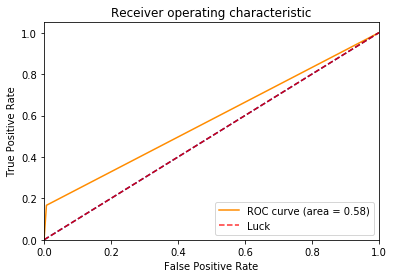

timestamp =  2017-05-19 19:00:42
auc_score =  0.550855203029 	feature importances: [ 0.34  0.48  0.18  0.  ]


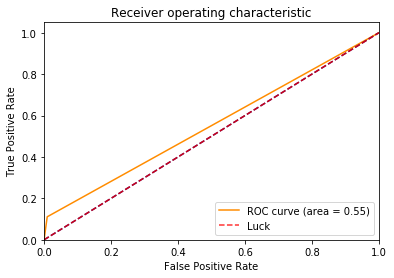

timestamp =  2017-05-19 20:00:42
auc_score =  0.51095116856 	feature importances: [ 0.42  0.34  0.24  0.  ]
timestamp =  2017-05-19 21:00:42
auc_score =  0.49882629108 	feature importances: [ 0.48  0.38  0.14  0.  ]
timestamp =  2017-05-19 22:00:42
auc_score =  0.526604068858 	feature importances: [ 0.32  0.32  0.36  0.  ]
timestamp =  2017-05-19 23:00:42
auc_score =  0.514285714286 	feature importances: [ 0.42  0.36  0.22  0.  ]
timestamp =  2017-05-20 00:00:42
auc_score =  0.523093937028 	feature importances: [ 0.44  0.32  0.24  0.  ]
timestamp =  2017-05-20 01:00:42
auc_score =  0.499414519906 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-20 02:00:42
auc_score =  0.496478873239 	feature importances: [ 0.32  0.42  0.26  0.  ]
timestamp =  2017-05-20 03:00:42
auc_score =  0.49882629108 	feature importances: [ 0.36  0.42  0.22  0.  ]
timestamp =  2017-05-20 04:00:42
auc_score =  0.494165694282 	feature importances: [ 0.3   0.34  0.36  0.  ]
timestamp =  2017-05-2

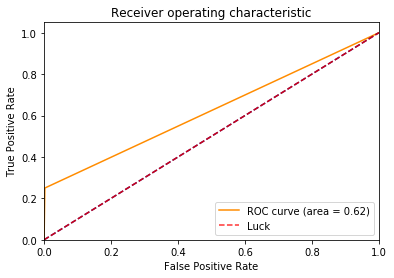

timestamp =  2017-05-20 12:00:42
auc_score =  0.499416569428 	feature importances: [ 0.42  0.32  0.26  0.  ]
timestamp =  2017-05-20 13:00:42
auc_score =  0.526610916634 	feature importances: [ 0.3   0.22  0.48  0.  ]
timestamp =  2017-05-20 14:00:42
auc_score =  0.498834498834 	feature importances: [ 0.32  0.34  0.34  0.  ]
timestamp =  2017-05-20 15:00:42
auc_score =  0.539335664336 	feature importances: [ 0.58  0.18  0.24  0.  ]
timestamp =  2017-05-20 16:00:42
auc_score =  0.536421911422 	feature importances: [ 0.28  0.34  0.38  0.  ]
timestamp =  2017-05-20 17:00:42
auc_score =  0.5 	feature importances: [ 0.64  0.24  0.12  0.  ]
timestamp =  2017-05-20 18:00:42
auc_score =  0.498834498834 	feature importances: [ 0.36  0.28  0.36  0.  ]
timestamp =  2017-05-20 19:00:42
auc_score =  0.510975135975 	feature importances: [ 0.42  0.18  0.4   0.  ]
timestamp =  2017-05-20 20:00:42
auc_score =  0.497086247086 	feature importances: [ 0.28  0.34  0.38  0.  ]
timestamp =  2017-05-20 21:00:

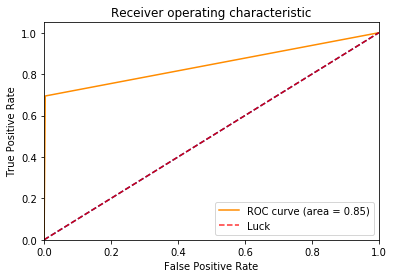

timestamp =  2017-05-20 23:00:42
auc_score =  0.941106851142 	feature importances: [ 0.46  0.24  0.3   0.  ]


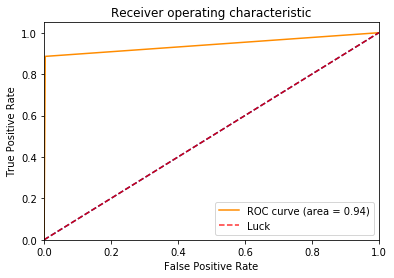

timestamp =  2017-05-21 00:00:42
auc_score =  0.885388305458 	feature importances: [ 0.34  0.38  0.26  0.02]


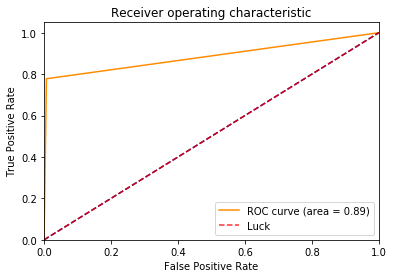

timestamp =  2017-05-21 01:00:42
auc_score =  0.883054583171 	feature importances: [ 0.28  0.26  0.44  0.02]


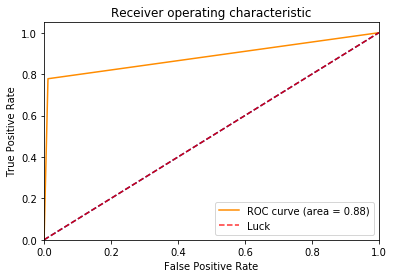

timestamp =  2017-05-21 02:00:42
auc_score =  0.898703272539 	feature importances: [ 0.46  0.26  0.28  0.  ]


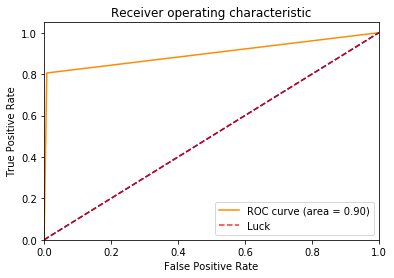

timestamp =  2017-05-21 03:00:42
auc_score =  0.512726098191 	feature importances: [ 0.42  0.3   0.28  0.  ]
timestamp =  2017-05-21 04:00:42
auc_score =  0.499418604651 	feature importances: [ 0.4   0.32  0.26  0.02]
timestamp =  2017-05-21 05:00:42
auc_score =  0.498255813953 	feature importances: [ 0.38  0.32  0.3   0.  ]
timestamp =  2017-05-21 06:00:42
auc_score =  0.512724744535 	feature importances: [ 0.48  0.16  0.34  0.02]
timestamp =  2017-05-21 07:00:42
auc_score =  0.5 	feature importances: [ 0.38  0.44  0.18  0.  ]
timestamp =  2017-05-21 08:00:42
auc_score =  0.523121200362 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-21 09:00:42
auc_score =  0.510396455827 	feature importances: [ 0.32  0.36  0.32  0.  ]
timestamp =  2017-05-21 10:00:42
auc_score =  0.498835855646 	feature importances: [ 0.26  0.36  0.38  0.  ]
timestamp =  2017-05-21 11:00:42
auc_score =  0.539920450136 	feature importances: [ 0.4   0.28  0.32  0.  ]
timestamp =  2017-05-21 12:00:

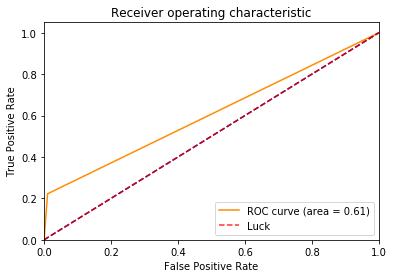

timestamp =  2017-05-21 18:00:42
auc_score =  0.499417249417 	feature importances: [ 0.46  0.34  0.2   0.  ]
timestamp =  2017-05-21 19:00:42
auc_score =  0.499417927823 	feature importances: [ 0.34  0.42  0.24  0.  ]
timestamp =  2017-05-21 20:00:42
auc_score =  0.513888888889 	feature importances: [ 0.4   0.44  0.14  0.02]
timestamp =  2017-05-21 21:00:42
auc_score =  0.509232311473 	feature importances: [ 0.36  0.42  0.22  0.  ]
timestamp =  2017-05-21 22:00:42
auc_score =  0.719311861337 	feature importances: [ 0.44  0.16  0.4   0.  ]


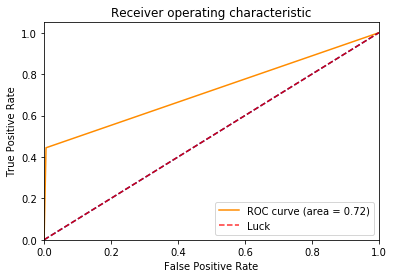

timestamp =  2017-05-21 23:00:42
auc_score =  0.583968069183 	feature importances: [ 0.5   0.34  0.16  0.  ]


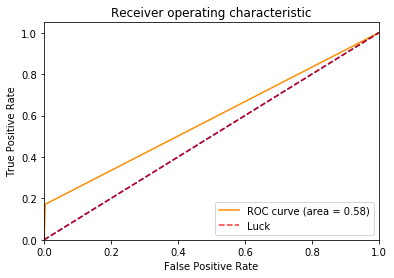

timestamp =  2017-05-22 00:00:42
auc_score =  0.51330749354 	feature importances: [ 0.54  0.32  0.14  0.  ]
timestamp =  2017-05-22 01:00:42
auc_score =  0.621511627907 	feature importances: [ 0.3   0.38  0.32  0.  ]


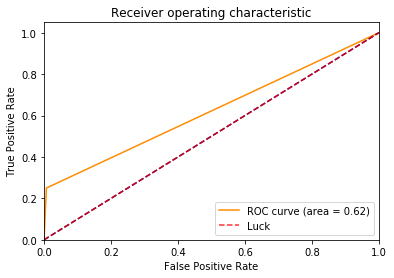

timestamp =  2017-05-22 02:00:42
auc_score =  0.499418604651 	feature importances: [ 0.48  0.32  0.2   0.  ]
timestamp =  2017-05-22 03:00:42
auc_score =  0.498833138856 	feature importances: [ 0.26  0.3   0.44  0.  ]
timestamp =  2017-05-22 04:00:42
auc_score =  0.5 	feature importances: [ 0.34  0.16  0.5   0.  ]
timestamp =  2017-05-22 05:00:42
auc_score =  0.498833138856 	feature importances: [ 0.44  0.26  0.3   0.  ]
timestamp =  2017-05-22 06:00:42
auc_score =  0.497086247086 	feature importances: [ 0.28  0.24  0.48  0.  ]
timestamp =  2017-05-22 07:00:42
auc_score =  0.497668997669 	feature importances: [ 0.36  0.24  0.4   0.  ]
timestamp =  2017-05-22 08:00:42
auc_score =  0.512140637141 	feature importances: [ 0.46  0.28  0.26  0.  ]
timestamp =  2017-05-22 09:00:42
auc_score =  0.499417249417 	feature importances: [ 0.42  0.36  0.22  0.  ]
timestamp =  2017-05-22 10:00:42
auc_score =  0.635392385392 	feature importances: [ 0.3   0.42  0.28  0.  ]


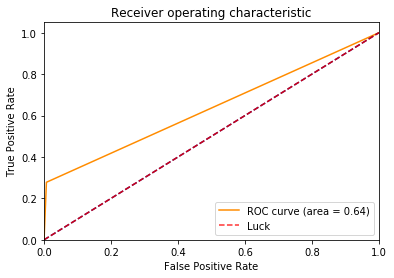

timestamp =  2017-05-22 11:00:42
auc_score =  0.5 	feature importances: [ 0.44  0.34  0.22  0.  ]
timestamp =  2017-05-22 12:00:42
auc_score =  0.498834498834 	feature importances: [ 0.38  0.3   0.32  0.  ]
timestamp =  2017-05-22 13:00:42
auc_score =  0.5 	feature importances: [ 0.34  0.5   0.16  0.  ]
timestamp =  2017-05-22 14:00:42
auc_score =  0.5 	feature importances: [ 0.44  0.34  0.22  0.  ]
timestamp =  2017-05-22 15:00:42
auc_score =  0.524864024864 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-22 16:00:42
auc_score =  0.497668997669 	feature importances: [ 0.32  0.24  0.44  0.  ]
timestamp =  2017-05-22 17:00:42
auc_score =  0.524864024864 	feature importances: [ 0.36  0.38  0.26  0.  ]
timestamp =  2017-05-22 18:00:42
auc_score =  0.498251748252 	feature importances: [ 0.3   0.36  0.34  0.  ]
timestamp =  2017-05-22 19:00:42
auc_score =  0.527195027195 	feature importances: [ 0.44  0.32  0.22  0.02]
timestamp =  2017-05-22 20:00:42
auc_score =  0.4976

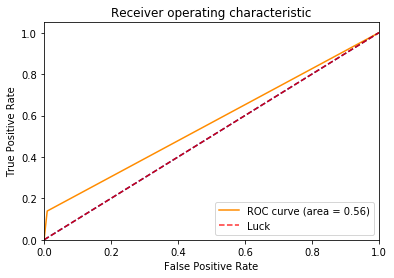

timestamp =  2017-05-22 23:00:42
auc_score =  0.59358974359 	feature importances: [ 0.44  0.24  0.32  0.  ]


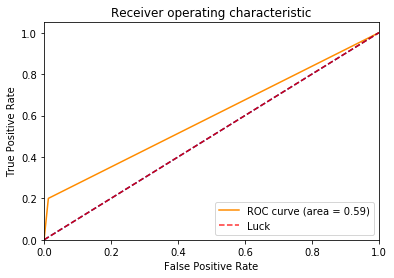

timestamp =  2017-05-23 00:00:42
auc_score =  0.512140637141 	feature importances: [ 0.16  0.48  0.36  0.  ]
timestamp =  2017-05-23 01:00:42
auc_score =  0.499417249417 	feature importances: [ 0.28  0.42  0.3   0.  ]
timestamp =  2017-05-23 02:00:42
auc_score =  0.527194347206 	feature importances: [ 0.56  0.28  0.16  0.  ]
timestamp =  2017-05-23 03:00:42
auc_score =  0.512144702842 	feature importances: [ 0.34  0.26  0.38  0.02]
timestamp =  2017-05-23 04:00:42
auc_score =  0.499419279907 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-23 05:00:42
auc_score =  0.51330749354 	feature importances: [ 0.3   0.26  0.42  0.02]
timestamp =  2017-05-23 06:00:42
auc_score =  0.512144702842 	feature importances: [ 0.3   0.32  0.36  0.02]
timestamp =  2017-05-23 07:00:42
auc_score =  0.498838559814 	feature importances: [ 0.42  0.28  0.28  0.02]
timestamp =  2017-05-23 08:00:42
auc_score =  0.647545219638 	feature importances: [ 0.4   0.34  0.26  0.  ]


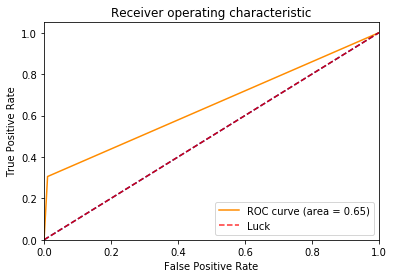

timestamp =  2017-05-23 09:00:42
auc_score =  0.595478036176 	feature importances: [ 0.38  0.32  0.3   0.  ]


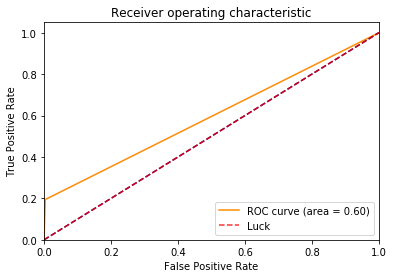

timestamp =  2017-05-23 10:00:42
auc_score =  0.498837209302 	feature importances: [ 0.4   0.24  0.36  0.  ]
timestamp =  2017-05-23 11:00:42
auc_score =  0.5 	feature importances: [ 0.3   0.22  0.46  0.02]
timestamp =  2017-05-23 12:00:42
auc_score =  0.499418604651 	feature importances: [ 0.4   0.44  0.16  0.  ]
timestamp =  2017-05-23 13:00:42
auc_score =  0.5 	feature importances: [ 0.4   0.28  0.32  0.  ]
timestamp =  2017-05-23 14:00:42
auc_score =  0.497674418605 	feature importances: [ 0.26  0.42  0.32  0.  ]
timestamp =  2017-05-23 15:00:42
auc_score =  0.494868871152 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-23 16:00:42
auc_score =  0.497206703911 	feature importances: [ 0.2  0.4  0.4  0. ]
timestamp =  2017-05-23 17:00:42
auc_score =  0.498905908096 	feature importances: [ 0.36  0.32  0.32  0.  ]
timestamp =  2017-05-23 18:00:42
auc_score =  0.498927038627 	feature importances: [ 0.4   0.26  0.34  0.  ]
timestamp =  2017-05-23 19:00:42
auc_score = 

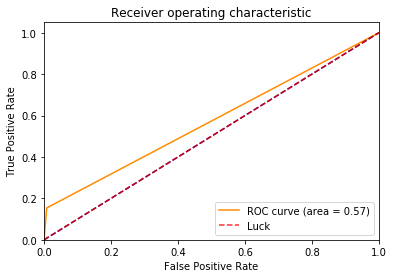

timestamp =  2017-05-24 00:00:42
auc_score =  0.5 	feature importances: [ 0.46  0.18  0.36  0.  ]
timestamp =  2017-05-24 01:00:42
auc_score =  0.517571548822 	feature importances: [ 0.32  0.32  0.36  0.  ]
timestamp =  2017-05-24 02:00:42
auc_score =  0.509248913718 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-24 03:00:42
auc_score =  0.527777777778 	feature importances: [ 0.3   0.24  0.46  0.  ]
timestamp =  2017-05-24 04:00:42
auc_score =  0.540281625115 	feature importances: [ 0.42  0.2   0.38  0.  ]
timestamp =  2017-05-24 05:00:42
auc_score =  0.497693726937 	feature importances: [ 0.46  0.28  0.26  0.  ]
timestamp =  2017-05-24 06:00:42
auc_score =  0.526854416744 	feature importances: [ 0.24  0.38  0.38  0.  ]
timestamp =  2017-05-24 07:00:42
auc_score =  0.5 	feature importances: [ 0.38  0.3   0.32  0.  ]
timestamp =  2017-05-24 08:00:42
auc_score =  0.499076638966 	feature importances: [ 0.28  0.2   0.52  0.  ]
timestamp =  2017-05-24 14:00:42
auc_scor

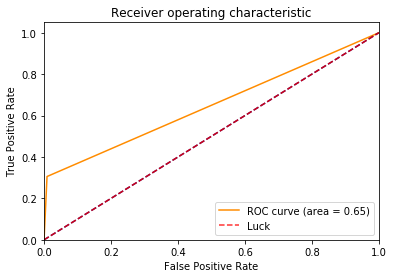

timestamp =  2017-05-25 01:00:42
auc_score =  0.562657114128 	feature importances: [ 0.46  0.32  0.22  0.  ]


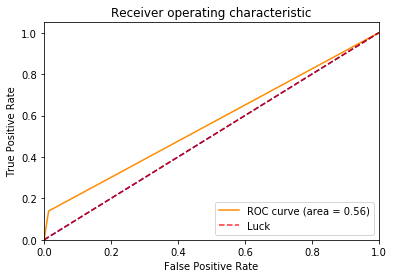

timestamp =  2017-05-25 02:00:42
auc_score =  0.79011627907 	feature importances: [ 0.36  0.34  0.3   0.  ]


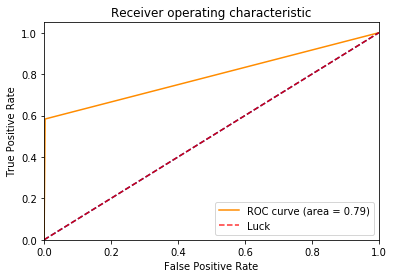

timestamp =  2017-05-25 03:00:42
auc_score =  0.655660377358 	feature importances: [ 0.42  0.28  0.3   0.  ]


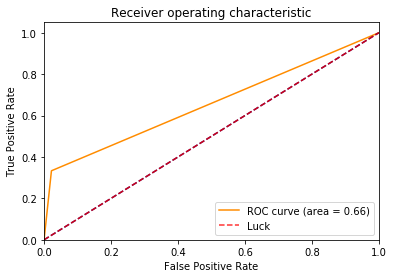

timestamp =  2017-05-25 04:00:42
auc_score =  0.747641509434 	feature importances: [ 0.32  0.36  0.32  0.  ]


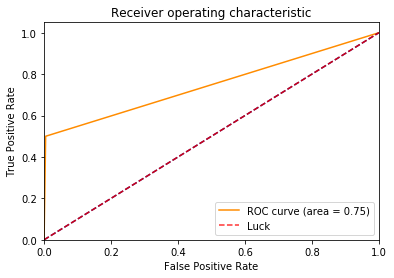

timestamp =  2017-05-25 05:00:42
auc_score =  0.605607966457 	feature importances: [ 0.18  0.4   0.42  0.  ]


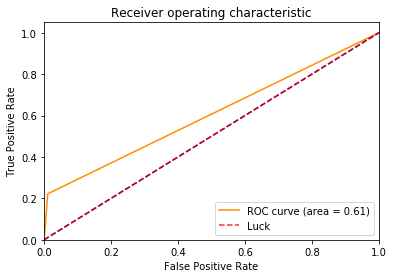

timestamp =  2017-05-25 06:00:42
auc_score =  0.499213836478 	feature importances: [ 0.32  0.22  0.46  0.  ]
timestamp =  2017-05-25 07:00:42
auc_score =  0.743710691824 	feature importances: [ 0.34  0.36  0.3   0.  ]


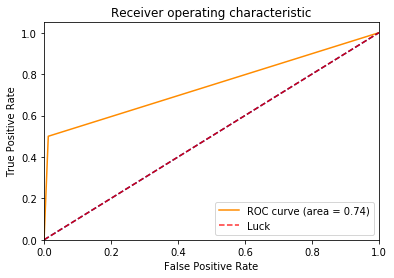

timestamp =  2017-05-25 08:00:42
auc_score =  0.5 	feature importances: [ 0.26  0.5   0.24  0.  ]
timestamp =  2017-05-25 09:00:42
auc_score =  0.512378314871 	feature importances: [ 0.5  0.3  0.2  0. ]
timestamp =  2017-05-25 10:00:42
auc_score =  0.566414244781 	feature importances: [ 0.34  0.36  0.3   0.  ]


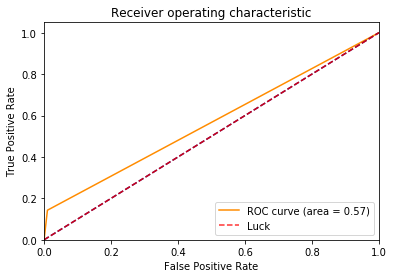

timestamp =  2017-05-25 11:00:42
auc_score =  0.510567951318 	feature importances: [ 0.38  0.3   0.32  0.  ]
timestamp =  2017-05-25 12:00:42
auc_score =  0.498682476943 	feature importances: [ 0.44  0.3   0.26  0.  ]
timestamp =  2017-05-25 13:00:42
auc_score =  0.498742138365 	feature importances: [ 0.24  0.42  0.34  0.  ]
timestamp =  2017-05-25 14:00:42
auc_score =  0.498796630566 	feature importances: [ 0.28  0.5   0.22  0.  ]
timestamp =  2017-05-25 15:00:42
auc_score =  0.516090358405 	feature importances: [ 0.28  0.4   0.32  0.  ]
timestamp =  2017-05-25 16:00:42
auc_score =  0.513294358568 	feature importances: [ 0.34  0.44  0.22  0.  ]
timestamp =  2017-05-25 17:00:42
auc_score =  0.5 	feature importances: [ 0.18  0.44  0.38  0.  ]
timestamp =  2017-05-25 18:00:42
auc_score =  0.5 	feature importances: [ 0.28  0.4   0.32  0.  ]
timestamp =  2017-05-25 19:00:42
auc_score =  0.524794484222 	feature importances: [ 0.2  0.4  0.4  0. ]
timestamp =  2017-05-25 20:00:42
auc_score = 

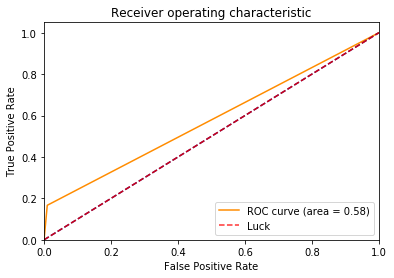

timestamp =  2017-05-26 01:00:42
auc_score =  0.553171765329 	feature importances: [ 0.42  0.36  0.22  0.  ]


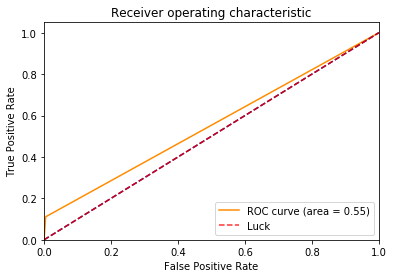

timestamp =  2017-05-26 02:00:42
auc_score =  0.512696993776 	feature importances: [ 0.48  0.28  0.24  0.  ]
timestamp =  2017-05-26 03:00:42
auc_score =  0.513292941332 	feature importances: [ 0.32  0.36  0.32  0.  ]
timestamp =  2017-05-26 04:00:42
auc_score =  0.540474771553 	feature importances: [ 0.66  0.16  0.18  0.  ]
timestamp =  2017-05-26 05:00:42
auc_score =  0.49821215733 	feature importances: [ 0.34  0.44  0.22  0.  ]
timestamp =  2017-05-26 06:00:42
auc_score =  0.499404052443 	feature importances: [ 0.36  0.38  0.26  0.  ]
timestamp =  2017-05-26 07:00:42
auc_score =  0.499404052443 	feature importances: [ 0.14  0.34  0.52  0.  ]
timestamp =  2017-05-26 08:00:42
auc_score =  0.608131373328 	feature importances: [ 0.26  0.42  0.32  0.  ]


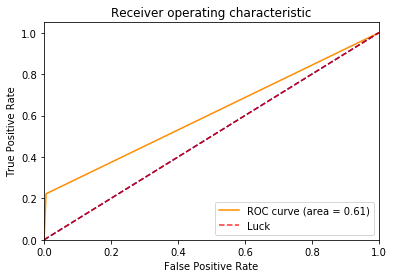

timestamp =  2017-05-26 09:00:42
auc_score =  0.564074516043 	feature importances: [ 0.44  0.14  0.42  0.  ]


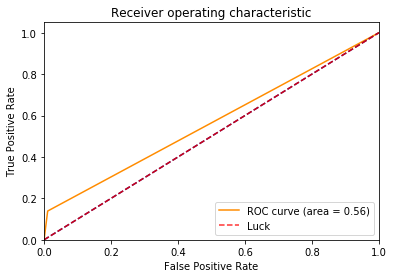

timestamp =  2017-05-26 10:00:42
auc_score =  0.594835587377 	feature importances: [ 0.42  0.26  0.32  0.  ]


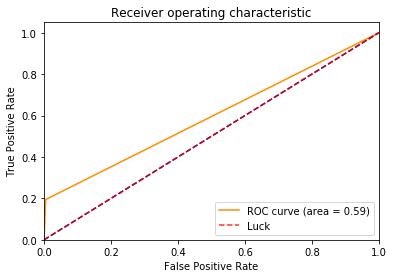

timestamp =  2017-05-26 11:00:42
auc_score =  0.538124754034 	feature importances: [ 0.3   0.28  0.4   0.02]
timestamp =  2017-05-26 12:00:42
auc_score =  0.498822143698 	feature importances: [ 0.36  0.36  0.28  0.  ]
timestamp =  2017-05-26 13:00:42
auc_score =  0.512711032587 	feature importances: [ 0.24  0.46  0.3   0.  ]
timestamp =  2017-05-26 14:00:42
auc_score =  0.5 	feature importances: [ 0.44  0.26  0.3   0.  ]
timestamp =  2017-05-26 15:00:42
auc_score =  0.538133097762 	feature importances: [ 0.3   0.34  0.32  0.04]
timestamp =  2017-05-26 16:00:42
auc_score =  0.499417249417 	feature importances: [ 0.4  0.3  0.3  0. ]
timestamp =  2017-05-26 17:00:42
auc_score =  0.498251748252 	feature importances: [ 0.32  0.28  0.4   0.  ]
timestamp =  2017-05-26 18:00:42
auc_score =  0.499419279907 	feature importances: [ 0.32  0.18  0.5   0.  ]
timestamp =  2017-05-26 19:00:42
auc_score =  0.49593495935 	feature importances: [ 0.44  0.3   0.26  0.  ]
timestamp =  2017-05-26 20:00:42
au

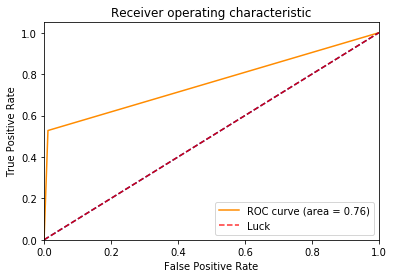

timestamp =  2017-05-26 23:00:42
auc_score =  0.498838559814 	feature importances: [ 0.32  0.42  0.26  0.  ]
timestamp =  2017-05-27 00:00:42
auc_score =  0.51214672861 	feature importances: [ 0.44  0.32  0.24  0.  ]
timestamp =  2017-05-27 01:00:42
auc_score =  0.5 	feature importances: [ 0.48  0.26  0.26  0.  ]
timestamp =  2017-05-27 02:00:42
auc_score =  0.513308168796 	feature importances: [ 0.3   0.42  0.28  0.  ]
timestamp =  2017-05-27 03:00:42
auc_score =  0.499419279907 	feature importances: [ 0.5   0.28  0.22  0.  ]
timestamp =  2017-05-27 04:00:42
auc_score =  0.606465350368 	feature importances: [ 0.38  0.34  0.28  0.  ]


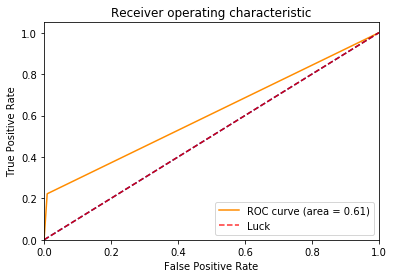

timestamp =  2017-05-27 05:00:42
auc_score =  0.704849012776 	feature importances: [ 0.36  0.28  0.36  0.  ]


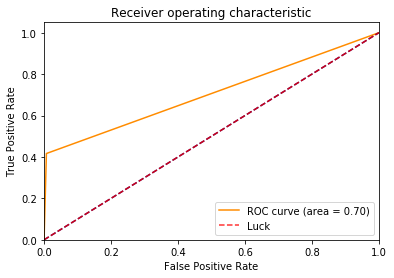

timestamp =  2017-05-27 06:00:42
auc_score =  0.753435927216 	feature importances: [ 0.5   0.32  0.18  0.  ]


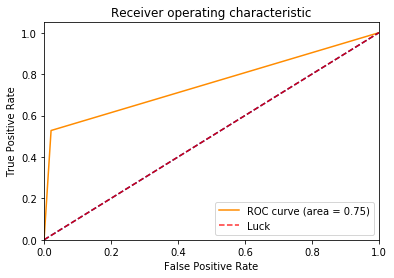

timestamp =  2017-05-27 07:00:42
auc_score =  0.55439411537 	feature importances: [ 0.44  0.26  0.3   0.  ]


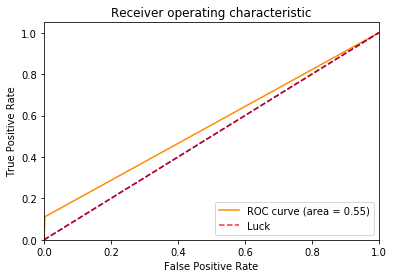

timestamp =  2017-05-27 08:00:42
auc_score =  0.732626790554 	feature importances: [ 0.5   0.38  0.12  0.  ]


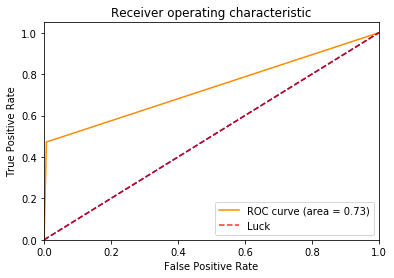

timestamp =  2017-05-27 09:00:42
auc_score =  0.580429732869 	feature importances: [ 0.4   0.34  0.26  0.  ]


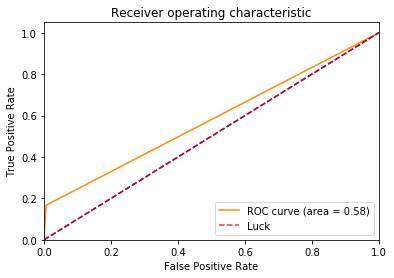

timestamp =  2017-05-27 10:00:42
auc_score =  0.498838559814 	feature importances: [ 0.46  0.24  0.3   0.  ]
timestamp =  2017-05-27 11:00:42
auc_score =  0.5 	feature importances: [ 0.34  0.42  0.24  0.  ]
timestamp =  2017-05-27 12:00:42
auc_score =  0.513888888889 	feature importances: [ 0.4   0.26  0.34  0.  ]
timestamp =  2017-05-27 13:00:42
auc_score =  0.498838559814 	feature importances: [ 0.24  0.46  0.3   0.  ]
timestamp =  2017-05-27 14:00:42
auc_score =  0.499419279907 	feature importances: [ 0.3   0.26  0.42  0.02]
timestamp =  2017-05-27 15:00:42
auc_score =  0.539343786295 	feature importances: [ 0.26  0.36  0.38  0.  ]
timestamp =  2017-05-27 16:00:42
auc_score =  0.578106852497 	feature importances: [ 0.3  0.4  0.3  0. ]


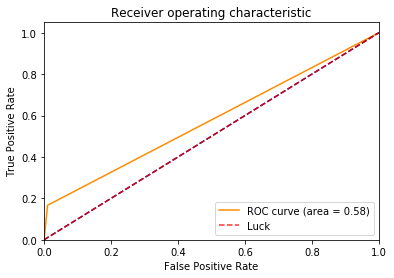

timestamp =  2017-05-27 17:00:42
auc_score =  0.732046070461 	feature importances: [ 0.38  0.34  0.28  0.  ]


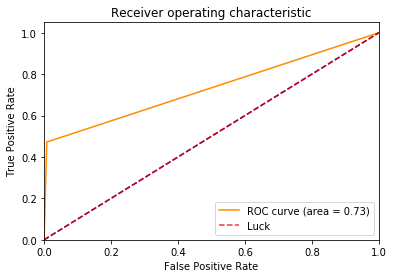

timestamp =  2017-05-27 18:00:42
auc_score =  0.499419279907 	feature importances: [ 0.32  0.36  0.32  0.  ]
timestamp =  2017-05-27 19:00:42
auc_score =  0.524874177313 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-27 20:00:42
auc_score =  0.498838559814 	feature importances: [ 0.36  0.44  0.2   0.  ]
timestamp =  2017-05-27 21:00:42
auc_score =  0.553813395277 	feature importances: [ 0.46  0.4   0.14  0.  ]


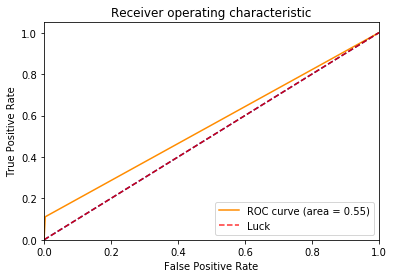

timestamp =  2017-05-27 22:00:42
auc_score =  0.498257839721 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-27 23:00:42
auc_score =  0.498257839721 	feature importances: [ 0.28  0.42  0.3   0.  ]
timestamp =  2017-05-28 00:00:42
auc_score =  0.803232675184 	feature importances: [ 0.14  0.32  0.52  0.02]


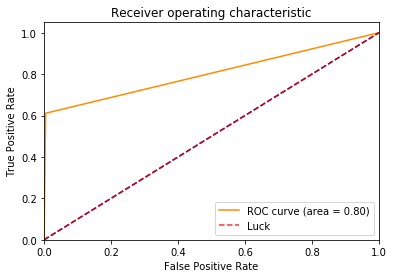

timestamp =  2017-05-28 01:00:42
auc_score =  0.71350129199 	feature importances: [ 0.22  0.38  0.4   0.  ]


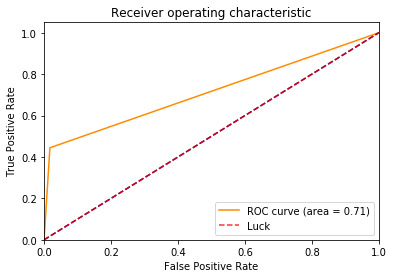

timestamp =  2017-05-28 02:00:42
auc_score =  0.777196382429 	feature importances: [ 0.34  0.26  0.4   0.  ]


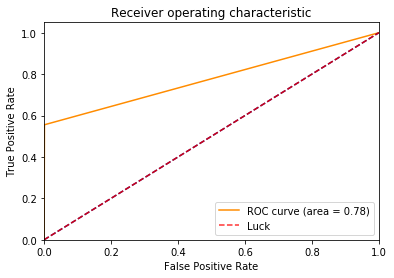

timestamp =  2017-05-28 03:00:42
auc_score =  0.510981912145 	feature importances: [ 0.32  0.28  0.4   0.  ]
timestamp =  2017-05-28 04:00:42
auc_score =  0.51330749354 	feature importances: [ 0.3   0.38  0.32  0.  ]
timestamp =  2017-05-28 05:00:42
auc_score =  0.499418604651 	feature importances: [ 0.28  0.38  0.34  0.  ]
timestamp =  2017-05-28 06:00:42
auc_score =  0.498257839721 	feature importances: [ 0.26  0.3   0.44  0.  ]
timestamp =  2017-05-28 07:00:42
auc_score =  0.499419279907 	feature importances: [ 0.26  0.28  0.46  0.  ]
timestamp =  2017-05-28 08:00:42
auc_score =  0.498838559814 	feature importances: [ 0.26  0.5   0.24  0.  ]
timestamp =  2017-05-28 09:00:42
auc_score =  0.52429345722 	feature importances: [ 0.36  0.5   0.14  0.  ]
timestamp =  2017-05-28 10:00:42
auc_score =  0.5 	feature importances: [ 0.38  0.48  0.14  0.  ]
timestamp =  2017-05-28 11:00:42
auc_score =  0.513308168796 	feature importances: [ 0.36  0.36  0.28  0.  ]
timestamp =  2017-05-28 12:00:42

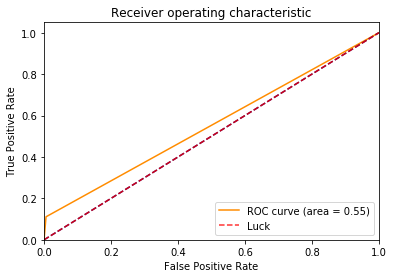

timestamp =  2017-05-28 15:00:42
auc_score =  0.498837209302 	feature importances: [ 0.44  0.42  0.14  0.  ]
timestamp =  2017-05-28 16:00:42
auc_score =  0.499418604651 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-28 17:00:42
auc_score =  0.5 	feature importances: [ 0.28  0.22  0.48  0.02]
timestamp =  2017-05-28 18:00:42
auc_score =  0.512726098191 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-28 19:00:42
auc_score =  0.521963824289 	feature importances: [ 0.24  0.52  0.24  0.  ]
timestamp =  2017-05-28 20:00:42
auc_score =  0.498837209302 	feature importances: [ 0.42  0.34  0.24  0.  ]
timestamp =  2017-05-28 21:00:42
auc_score =  0.496511627907 	feature importances: [ 0.4  0.3  0.3  0. ]
timestamp =  2017-05-28 22:00:42
auc_score =  0.596059431525 	feature importances: [ 0.28  0.4   0.32  0.  ]


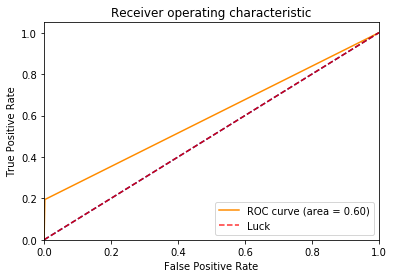

timestamp =  2017-05-28 23:00:42
auc_score =  0.510797342193 	feature importances: [ 0.36  0.38  0.26  0.  ]
timestamp =  2017-05-29 00:00:42
auc_score =  0.635981912145 	feature importances: [ 0.34  0.44  0.22  0.  ]


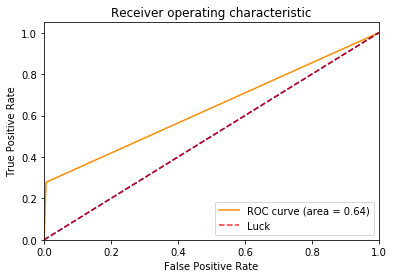

timestamp =  2017-05-29 01:00:42
auc_score =  0.498837209302 	feature importances: [ 0.36  0.38  0.26  0.  ]
timestamp =  2017-05-29 02:00:42
auc_score =  0.497674418605 	feature importances: [ 0.32  0.42  0.26  0.  ]
timestamp =  2017-05-29 03:00:42
auc_score =  0.499418604651 	feature importances: [ 0.36  0.4   0.24  0.  ]
timestamp =  2017-05-29 04:00:42
auc_score =  0.699031007752 	feature importances: [ 0.38  0.2   0.42  0.  ]


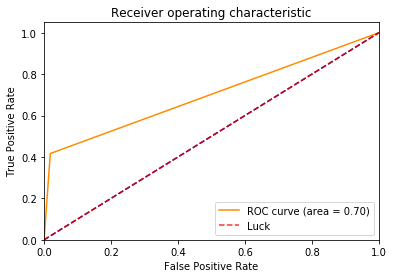

timestamp =  2017-05-29 05:00:42
auc_score =  0.540503875969 	feature importances: [ 0.5  0.2  0.3  0. ]
timestamp =  2017-05-29 06:00:42
auc_score =  0.497093023256 	feature importances: [ 0.54  0.22  0.24  0.  ]
timestamp =  2017-05-29 07:00:42
auc_score =  0.499418604651 	feature importances: [ 0.4  0.3  0.3  0. ]
timestamp =  2017-05-29 08:00:42
auc_score =  0.512726098191 	feature importances: [ 0.32  0.44  0.24  0.  ]
timestamp =  2017-05-29 09:00:42
auc_score =  0.843733850129 	feature importances: [ 0.36  0.42  0.22  0.  ]


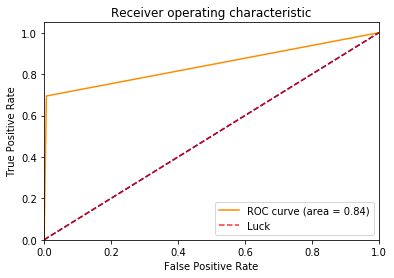

timestamp =  2017-05-29 10:00:42
auc_score =  0.51330749354 	feature importances: [ 0.42  0.2   0.38  0.  ]
timestamp =  2017-05-29 11:00:42
auc_score =  0.688049095607 	feature importances: [ 0.34  0.32  0.34  0.  ]


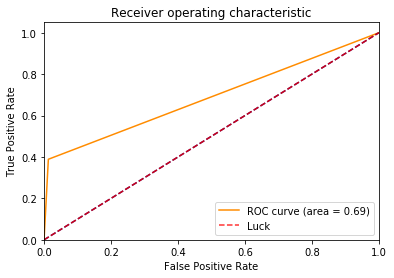

timestamp =  2017-05-29 12:00:42
auc_score =  0.499419279907 	feature importances: [ 0.46  0.28  0.26  0.  ]
timestamp =  2017-05-29 13:00:42
auc_score =  0.5 	feature importances: [ 0.38  0.32  0.3   0.  ]
timestamp =  2017-05-29 14:00:42
auc_score =  0.5 	feature importances: [ 0.36  0.28  0.36  0.  ]
timestamp =  2017-05-29 15:00:42
auc_score =  0.512726098191 	feature importances: [ 0.38  0.4   0.2   0.02]
timestamp =  2017-05-29 16:00:42
auc_score =  0.510981912145 	feature importances: [ 0.44  0.26  0.3   0.  ]
timestamp =  2017-05-29 17:00:42
auc_score =  0.511563307494 	feature importances: [ 0.4   0.26  0.34  0.  ]
timestamp =  2017-05-29 18:00:42
auc_score =  0.5 	feature importances: [ 0.3  0.4  0.3  0. ]
timestamp =  2017-05-29 19:00:42
auc_score =  0.513888888889 	feature importances: [ 0.32  0.34  0.34  0.  ]
timestamp =  2017-05-29 20:00:42
auc_score =  0.499418604651 	feature importances: [ 0.46  0.22  0.32  0.  ]
timestamp =  2017-05-29 21:00:42
auc_score =  0.49651162

In [21]:
#find min and max timestamps

start = Fpl2.index.min()
end = Fpl2.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = Fpl2[(Fpl2.index >= ref_start) & (Fpl2.index < ref_end)]
    #print('ref_df = ', ref_df)
    #print("In while loop: ref_df: ", ref_df)
    sub_df = Fpl2[(Fpl2.index >= ref_end) & (Fpl2.index < ti)]
    #print('sub_df = ', sub_df)
    #print("In while loop: sub_df: ", sub_df)
    
    ref_count = ref_df.shape[0]
    sub_count = sub_df.shape[0] 
    if ref_count < 10 or sub_count < 3:
        auc_score == 0.5
        ti = ti + sub
        count=count+1
        continue
    
    print("timestamp = ", ref_end)
    auc_score = check_for_anomaly(ref_df, sub_df)
    Fpl2.loc[(Fpl2.index>=ref_end) & (Fpl2.index<=ti),['auc_score']] = auc_score
    #print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    


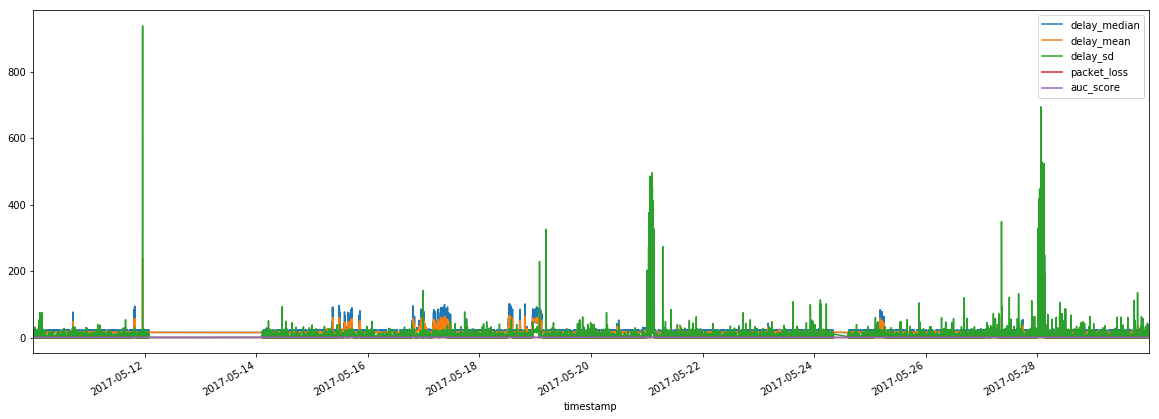

In [22]:
Fpl2.plot(figsize=(20,7))

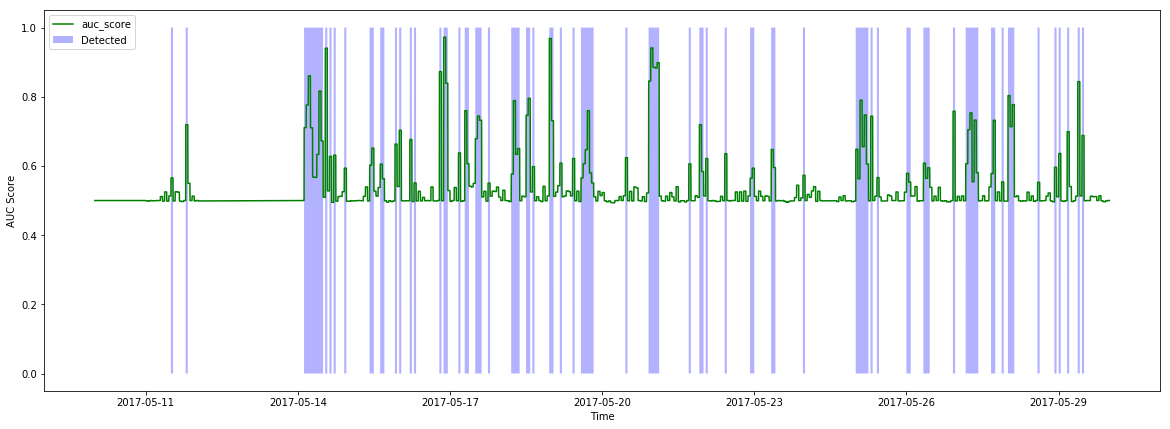

In [23]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('AUC Score')
ax.legend(loc='upper left')

/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


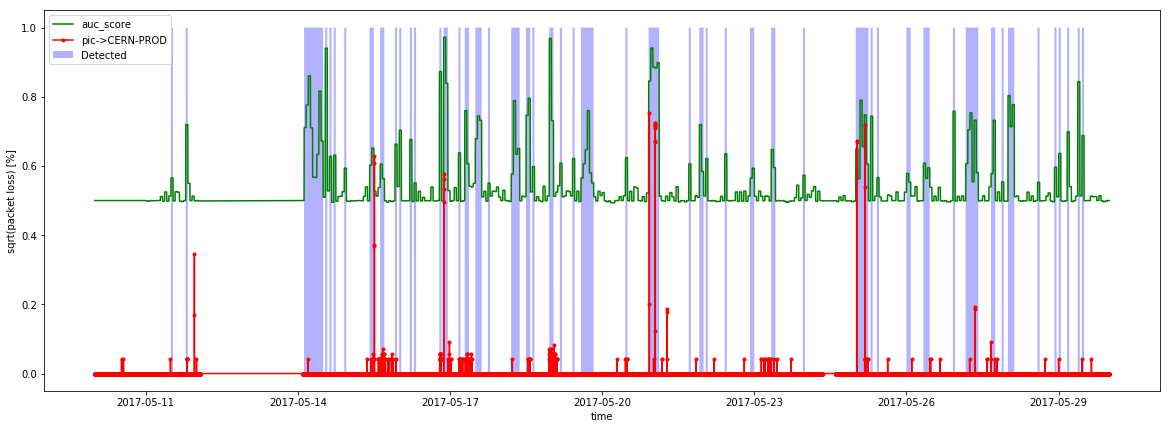

In [24]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', linestyle='-', marker='.', c='r', label=sS+'->'+dS)
ax.set_xlabel('time')
ax.set_ylabel('sqrt(packet loss) [%]')
ax.legend(loc='upper left')
plt.show()

In [25]:
print(Fpl2)

                     delay_median  delay_mean   delay_sd  packet_loss  \
timestamp                                                               
2017-05-10 00:00:42        15.300   15.324867   0.221191          0.0   
2017-05-10 00:00:46        15.300   15.545550   5.617409          0.0   
2017-05-10 00:01:42        15.290   15.406417   1.502225          0.0   
2017-05-10 00:01:46        15.300   15.324650   0.146248          0.0   
2017-05-10 00:02:42        15.330   15.368233   0.382339          0.0   
2017-05-10 00:02:46        15.330   15.342733   0.100159          0.0   
2017-05-10 00:03:42        15.310   15.329317   0.139697          0.0   
2017-05-10 00:03:46        15.320   15.347617   0.297025          0.0   
2017-05-10 00:04:42        15.310   15.542367   3.540416          0.0   
2017-05-10 00:04:46        15.320   15.329467   0.066114          0.0   
2017-05-10 00:05:42        15.310   15.379550   0.727224          0.0   
2017-05-10 00:05:51        22.985   15.401933   1.2

In [26]:
#Fpl2_avg_auc_holder = Fpl2.auc_score
#Fpl2_avg_auc = Fpl2_avg_auc_holder[:'2017-08-15 00:00:00']
#Fpl2_avg_auc.mean()
#ref_start_df = pd.DataFrame(columns=['timestamp'])

#columns1 = ['timestamp', 'auc_score']
#ref_start_df = pd.DataFrame(columns=columns1) 
#ref_start_df.set_index('timestamp')

#print(ref_start_df)




In [27]:
Fpl2_avg_pkt_holder = Fpl2.packet_loss
#holds all the auc scores

timestamp_np = np.array([])
pkt_score_np = np.array([])

start = Fpl2.index.min()
end = Fpl2.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start
count=0
while ti < end + 1 * Minute():
#while start < end:
    ref_start = ti
    ref_end = ti+sub
    
    
    timestamp_np = np.append(timestamp_np, ref_start)
    #create a dataframe that stores the starting time of the each hour
    
    Fpl2_avg_pkt = math.sqrt(Fpl2_avg_pkt_holder[ref_start:ref_end].mean())
    #average packet loss score for every hour    
    
    pkt_score_np = np.append(pkt_score_np, Fpl2_avg_pkt)
    
    #start = start + sub
    
    ti = ti + sub
    #count=count+1
    #if count>2: break

timestamp1_df = pd.DataFrame(timestamp_np[:], columns=['timestamp'])
pkt_score1_df = pd.DataFrame(pkt_score_np[:], columns=['avg_packet_loss'])

pkt_avg_df1 = pd.concat([timestamp1_df, pkt_score1_df], axis=1)

pkt_avg_df2 = pkt_avg_df1.set_index('timestamp')

print(pkt_avg_df2)


                     avg_packet_loss
timestamp                           
2017-05-10 00:00:42         0.000000
2017-05-10 01:00:42         0.000000
2017-05-10 02:00:42         0.000000
2017-05-10 03:00:42         0.000000
2017-05-10 04:00:42         0.000000
2017-05-10 05:00:42         0.000000
2017-05-10 06:00:42         0.000000
2017-05-10 07:00:42         0.000000
2017-05-10 08:00:42         0.000000
2017-05-10 09:00:42         0.000000
2017-05-10 10:00:42         0.000000
2017-05-10 11:00:42         0.000000
2017-05-10 12:00:42         0.003727
2017-05-10 13:00:42         0.003727
2017-05-10 14:00:42         0.000000
2017-05-10 15:00:42         0.000000
2017-05-10 16:00:42         0.000000
2017-05-10 17:00:42         0.000000
2017-05-10 18:00:42         0.000000
2017-05-10 19:00:42         0.000000
2017-05-10 20:00:42         0.000000
2017-05-10 21:00:42         0.000000
2017-05-10 22:00:42         0.000000
2017-05-10 23:00:42         0.000000
2017-05-11 00:00:42         0.000000
2

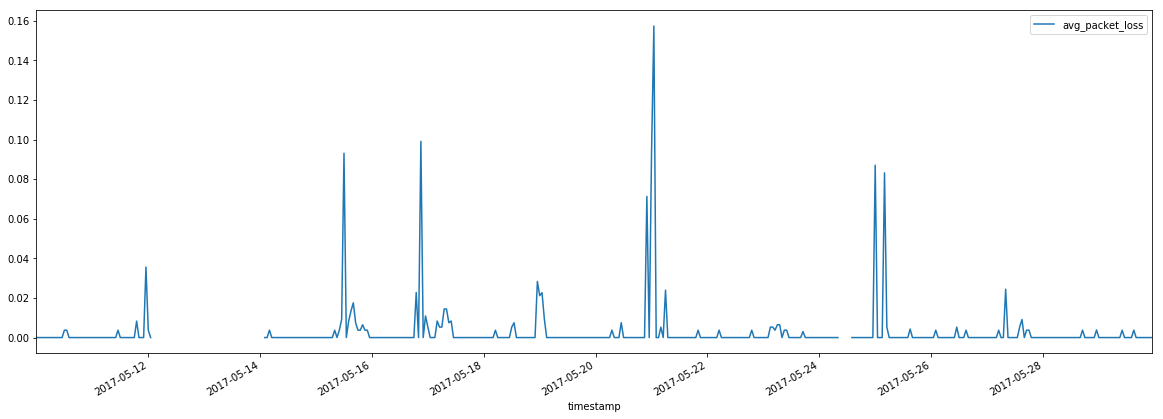

In [28]:
pkt_avg_df2.plot(figsize=(20,7))

In [29]:
# ax = pkt_avg_df2.plot()
# Fpl2.loc[:,'Detected'] = 0
# Fpl2.loc[Fpl2.auc_score>0.51,'Detected']=1
# Fpl2.plot(ax=ax, figsize=(20,7))
# ax.fill( Fpl2.Detected, 'b', alpha=0.3)

/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


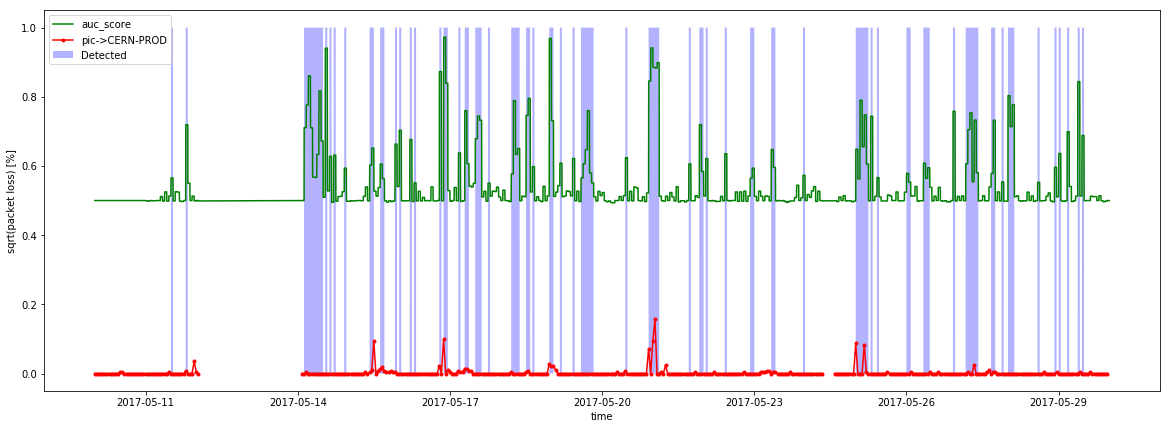

In [30]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.plot(timestamp1_df, pkt_avg_df2, ls='', linestyle='-', marker='.', c='r', label=sS+'->'+dS)
ax.set_xlabel('time')
ax.set_ylabel('sqrt(packet loss) [%]')
ax.legend(loc='upper left')
plt.show()